In [56]:
import pandas as pd
import numpy as np
from pymatgen.core import Composition
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.model_selection import train_test_split
import math
from joblib import Parallel, delayed
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from sklearn.model_selection import LeaveOneOut
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
from tqdm import tqdm
config = {
    "mathtext.fontset":'stix',
    "font.family":'serif',
    "font.serif": ['Arial'],
    "font.size": 24,
    'axes.unicode_minus': False 
}
plt.rcParams.update(config)
plt.rcParams['axes.unicode_minus'] = False  
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (8, 6),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.rcParams['figure.dpi'] = 400
plt.rcParams['axes.grid'] = False

In [8]:
def get_combined_features(data: pd.DataFrame):
    columns = data.columns
    A_features = []
    B_features = []
    O_features = []
    for column in columns:
        if str(column).__contains__('A'):
            A_features.append(column)
        elif str(column).__contains__('B'):
            B_features.append(column)
        elif str(column).__contains__('O'):
            O_features.append(column)

    for a_feature, b_feature, o_feature in zip(A_features, B_features, O_features):
        feature_name = str(a_feature).split('_')[1]
        feature_name = feature_name
        data['A-B_'+feature_name] = np.abs(data[a_feature] - data[b_feature])
        data['(A+B)-O_'+feature_name] = np.abs((data[a_feature] + data[b_feature])- data[o_feature])


    data = data.drop(columns=O_features)
    return data

In [5]:
base_metal_oxide = pd.read_csv('/data/single_perovskite_oxide.csv')
base_metal_oxide = base_metal_oxide.drop(columns = 'Unnamed: 0').reset_index(drop=True)
base_metal_oxide = base_metal_oxide.drop(columns = 'composition').reset_index(drop=True)
base_metal_oxide['composition'] = base_metal_oxide['formula'].map(Composition)
y_eg_abo3 = base_metal_oxide['target']

In [6]:
pysic_features_ABO3 = pd.read_csv('/data/pysic_features_ABO3.csv').drop(columns = 'Unnamed: 0')
pysic_labels = pysic_features_ABO3.columns.drop('formula')
pysic_labels

Index(['A_Density', 'B_Density', 'O_Density', 'A_dipole Polarizability',
       'B_dipole Polarizability', 'O_dipole Polarizability',
       'A_covalent Radius', 'B_covalent Radius', 'O_covalent Radius',
       'A_atomic Radius', 'B_atomic Radius', 'O_atomic Radius',
       'A_FirstIonization', 'B_FirstIonization', 'O_FirstIonization',
       'A_number of Valence Electrons', 'B_number of Valence Electrons',
       'O_number of Valence Electrons', 'A_number', 'B_number', 'O_number',
       'A_Period', 'B_Period', 'O_Period', 'A_Electronegativity',
       'B_Electronegativity', 'O_Electronegativity',
       'A_number of s+p Electrons', 'B_number of s+p Electrons',
       'O_number of s+p Electrons', 'A_number of d Electrons',
       'B_number of d Electrons', 'O_number of d Electrons', 'A_Mulliken EN',
       'B_Mulliken EN', 'O_Mulliken EN'],
      dtype='object')

In [9]:
pysic_features_ABO3 = pysic_features_ABO3[pysic_labels]
pysic_features_ABO3 = get_combined_features(pysic_features_ABO3)
pysic_features_ABO3

A_Density  B_Density  A_dipole Polarizability  B_dipole Polarizability  \
0       7.520       7.15                    192.0                    83.00   
1       2.990       8.86                     97.0                    55.00   
2       7.900       7.15                    158.0                    83.00   
3       4.470       7.15                    162.0                    83.00   
4       6.150       7.87                    215.0                    62.00   
5       7.520       8.86                    192.0                    55.00   
6       4.470       7.87                    162.0                    62.00   
7       6.150       7.15                    215.0                    83.00   
8       6.770       7.15                    216.0                    83.00   
9       7.010       7.15                    208.0                    83.00   
10      4.470       8.86                    162.0                    55.00   
11      9.320       7.15                    144.0                    83.00   
12      7.520       7.87                    192.0                    62.00   
13      7.010       8.86                    208.0                    55.00   
14      1.530       8.57                    319.8                    98.00   
15      8.550       7.31                    163.0                    65.00   
16      7.260       9.07                    200.0                   150.00   
17     13.300       1.85                    103.0                    37.74   
18      1.870       8.57                    400.9                    98.00   
19      6.970       5.32                    139.0                    40.00   
20      6.770       1.85                    205.0                    37.74   
21     11.300       7.29                     47.0                    53.00   
22      8.690       7.29                     46.0                    53.00   
23      1.740       4.54                     71.2                   100.00   
24      9.810       5.91                     48.0                    50.00   
25     11.900       8.57                     50.0                    98.00   
26     10.500      16.70                     55.0                    74.00   
27      7.900       2.70                    158.0                    57.80   
28      7.260       7.31                    200.0                    65.00   
29      9.810       7.31                     48.0                    65.00   
30      8.690       5.32                     46.0                    40.00   
31      5.240       6.51                    184.0                   112.00   
32      0.862       8.57                    289.7                    98.00   
33     11.900      16.70                     50.0                    74.00   
34      7.010       7.31                    208.0                    65.00   
35      1.870      16.70                    400.9                    74.00   
36      1.530      16.70                    319.8                    74.00   
37      1.540       4.54                    160.8                   100.00   
38      7.310       6.69                     65.0                    43.00   
39      5.240      13.30                    184.0                   103.00   
40      3.590       6.77                    272.0                   205.00   
41      3.590       7.29                    272.0                    53.00   
42      3.590       4.54                    272.0                   100.00   
43     11.300      13.30                     47.0                   103.00   
44      0.862      16.70                    289.7                    74.00   
45      0.971       8.57                    162.7                    98.00   
46     10.500       8.57                     55.0                    98.00   
47      2.640       7.29                    197.2                    53.00   
48      2.640       4.54                    197.2                   100.00   
49     11.300       4.54                     47.0                   100.00   
50      7.290       4.54  

In [10]:
re_data = pd.read_csv('/data/all_features_df.csv')
ABO3_atomic_features = pd.read_csv('/data/small_atomic_features_new.csv').drop(columns = 'Unnamed: 0')
atomic_features = pd.read_csv('/data/ao_features.csv')

In [11]:
atomic_labels = atomic_features.columns
select_atomic_labels = atomic_labels
atomic_features = atomic_features[select_atomic_labels]
atomic_features

A_atomic_hfomo  A_atomic_hpomo  A_atomic_lfumo  A_atomic_lpumo  \
0           -4.210348       -2.165658       -2.165658       -2.165658   
1           -4.210348       -2.165658       -2.165658       -2.165658   
2           -4.210348       -2.165658       -2.165658       -2.165658   
3           -4.210348       -2.165658       -2.165658       -2.165658   
4           -4.210348       -2.165658       -2.165658       -2.165658   
...               ...             ...             ...             ...   
72843       -3.709160       -3.709160       -0.900650       -0.900650   
72844       -3.709160       -3.709160       -0.900650       -0.900650   
72845       -3.709160       -3.709160       -0.900650       -0.900650   
72846       -3.709160       -3.709160       -0.900650       -0.900650   
72847       -3.709160       -3.709160       -0.900650       -0.900650   

       A_atomic_ea  A_atomic_ip  A_atomic_ea_by_half_charged_homo  \
0        -0.299291     4.230849                          1.754248   
1        -0.299291     4.230849                          1.754248   
2        -0.299291     4.230849                          1.754248   
3        -0.299291     4.230849                          1.754248   
4        -0.299291     4.230849                          1.754248   
...            ...          ...                               ...   
72843     1.114753     5.960128                          1.136460   
72844     1.114753     5.960128                          1.136460   
72845     1.114753     5.960128                          1.136460   
72846     1.114753     5.960128                          1.136460   
72847     1.114753     5.960128                          1.136460   

       A_atomic_ip_by_half_charged_homo  A_atomic_r_s_neg_1  \
0                              6.900584             1.90799   
1                              6.900584             1.90799   
2                              6.900584             1.90799   
3                              6.900584             1.90799   
4                              6.900584             1.90799   
...                                 ...                 ...   
72843                          5.964720             2.16695   
72844                          5.964720             2.16695   
72845                          5.964720             2.16695   
72846                          5.964720             2.16695   
72847                          5.964720             2.16695   

       A_atomic_r_val_neg_1  ...  B_atomic_ie_1  B_atomic_ie_2  \
0                   0.81939  ...       6.766510      16.485700   
1                   0.81939  ...       7.881010      17.084000   
2                   0.81939  ...       7.902400      16.187700   
3                   0.81939  ...       6.758850      14.000000   
4                   0.81939  ...       7.343920      14.632200   
...                     ...  ...            ...            ...   
72843               2.26615  ...       5.925526      11.667650   
72844               2.26615  ...       5.676880      13.749545   
72845               2.26615  ...       6.322594      12.498752   
72846               2.26615  ...       6.141961       0.000000   
72847               2.26615  ...       5.672820      13.243565   

       B_atomic_ndunf  B_atomic_ndval  B_atomic_npunf  B_atomic_npval  \
0                 5.0             5.0             0.0             0.0   
1                 3.0             7.0             0.0             0.0   
2                 4.0             6.0             0.0             0.0   
3                 6.0             4.0             0.0             0.0   
4                 0.0            10.0             4.0             2.0   
...               ...             ...             ...             ...   
72843             8.7             1.3             0.0             0.0   
72844             6.3             3.7             1.5             0.3   
72845             6.3             0.7             1.2             0.6   
72846             8.4

In [14]:
def get_combined_features(data: pd.DataFrame):
    columns = data.columns
    A_features = []
    B_features = []
    O_features = []
    for column in columns:
        if str(column).__contains__('A'):
            A_features.append(column)
        elif str(column).__contains__('B'):
            B_features.append(column)
        elif str(column).__contains__('O'):
            O_features.append(column)

    for a_feature, b_feature, o_feature in zip(A_features, B_features, O_features):
        feature_name = str(a_feature).split('_')[1]
        feature_name = feature_name
        data['A-B_'+feature_name] = np.abs(data[a_feature] - data[b_feature])
        data['(A+B)-O_'+feature_name] = np.abs((data[a_feature] + data[b_feature])- data[o_feature])


    data = data.drop(columns=O_features)
    return data

In [15]:
pysic_features = re_data[pysic_labels]
pysic_features =  get_combined_features(pysic_features)
pysic_features[['formula','Eg']] = re_data[['formula','Eg']]
pysic_features

A_Density  B_Density  A_dipole Polarizability  B_dipole Polarizability  \
0          3.896      7.150                    116.0                   83.000   
1          3.896      7.870                    116.0                   62.000   
2          3.896      6.510                    116.0                  112.000   
3          3.896      5.320                    116.0                   40.000   
4          3.896     13.300                    116.0                  103.000   
...          ...        ...                      ...                      ...   
35320      2.640      6.692                    197.2                  177.100   
35321      2.640      5.294                    197.2                  154.822   
35322      2.640      6.335                    197.2                  155.500   
35323      2.640      8.729                    197.2                  174.400   
35324      2.640      6.101                    197.2                  173.500   

       A_covalent Radius  B_covalent Radius  A_atomic Radius  B_atomic Radius  \
0                  152.8              122.0             1.65            1.400   
1                  152.8              116.0             1.65            1.400   
2                  152.8              154.0             1.65            1.550   
3                  152.8              121.0             1.65            1.250   
4                  152.8              152.0             1.65            1.550   
...                  ...                ...              ...              ...   
35320              185.0              160.3             2.00            1.760   
35321              185.0              144.7             2.00            1.610   
35322              185.0              150.4             2.00            1.670   
35323              185.0              159.7             2.00            1.760   
35324              185.0              154.9             2.00            1.715   

       A_FirstIonization  B_FirstIonization  ...  A-B_Electronegativity  \
0                 615.38             652.90  ...                  0.338   
1                 615.38             762.50  ...                  0.508   
2                 615.38             640.10  ...                  0.008   
3                 615.38             762.00  ...                  0.688   
4                 615.38             658.50  ...                  0.022   
...                  ...                ...  ...                    ...   
35320             549.50             566.11  ...                  0.233   
35321             549.50             643.93  ...                  0.305   
35322             549.50             602.68  ...                  0.437   
35323             549.50             571.63  ...                  0.224   
35324             549.50             571.72  ...                  0.296   

       (A+B)-O_Electronegativity  A-B_number of s+p Electrons  \
0                          0.458                          1.0   
1                          0.288                          0.0   
2                          0.788                          0.0   
3                          0.108                          2.0   
4                          0.818                          0.0   
...                          ...                          ...   
35320                      1.307                          0.0   
35321                      1.235                          0.0   
35322                      1.103                          0.6   
35323                      1.316                          0.0   
35324                      1.244                          0.0   

       (A+B)-O_number of s+p Electrons  A-B_number of d Electrons  \
0                                  3.0                        4.2   
1                                  2.0                        5.2   
2                                  2.0                        1.2   
3                                  0.0                        0.8   
4                                 

In [16]:
from scipy.stats import spearmanr
def remove_collinear_features(x, y,threshold):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model
        to generalize and improves the interpretability of the model.
        
    Inputs: 
        threshold: any features with correlations greater than this value are removed
    
    Output: 
        dataframe that contains only the non-highly-collinear features
    '''  
    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)
            
            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
#                 print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                x1 = x[col.values[0]]
                x2 = x[row.values[0]]
                corr1,p1 = spearmanr(x1, y)
                corr2,p2 = spearmanr(x2, y)
                if np.abs(corr1) < np.abs(corr2):
                    drop_cols.append(col.values[0])
                else:
                    drop_cols.append(row.values[0])
    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    x = x.drop(columns = drops)
    return x

In [17]:
feature_1 = pysic_features.copy(deep = True)
feature_1 = feature_1.drop_duplicates(subset='formula',keep='first').reset_index(drop = True)

In [18]:
y_eg = feature_1['Eg']
X_1 = feature_1
X_1 = X_1.drop(columns = ['formula','Eg'])
X_1 = remove_collinear_features(X_1,y_eg,0.8)
features_labels_1 = X_1.columns
X_1 = feature_1[features_labels_1]
X_1.columns

Index(['A_Density', 'B_Density', 'A_covalent Radius', 'B_atomic Radius',
       'B_FirstIonization', 'B_number of Valence Electrons',
       'A_number of s+p Electrons', 'B_number of s+p Electrons',
       'A_number of d Electrons', 'B_number of d Electrons', 'A-B_Density',
       '(A+B)-O_Density', 'A-B_atomic Radius', 'A-B_FirstIonization',
       'A-B_number of Valence Electrons',
       '(A+B)-O_number of Valence Electrons', 'A-B_Period', '(A+B)-O_Period',
       'A-B_Electronegativity', '(A+B)-O_Electronegativity',
       'A-B_number of s+p Electrons', '(A+B)-O_number of s+p Electrons',
       'A-B_number of d Electrons', '(A+B)-O_number of d Electrons',
       '(A+B)-O_Mulliken EN'],
      dtype='object')

In [19]:
pysic_best_feature = ['formula','Eg','A_Density','A_covalent Radius','B_atomic Radius','B_number of Valence Electrons',
                      'A_number of s+p Electrons','A_number of d Electrons','B_number of d Electrons',
                      'A-B_atomic Radius','A-B_number of Valence Electrons','(A+B)-O_number of d Electrons',
                      '(A+B)-O_Mulliken EN']
data_3 = pysic_features[pysic_best_feature].copy(deep = True)
data_3[select_atomic_labels] = re_data[select_atomic_labels]
data_3 = data_3.drop_duplicates(subset='formula',keep='first').reset_index(drop = True)

In [20]:
X_4 = data_3.copy(deep = True)
X_4 = X_4.drop(columns = ['formula','Eg'])
X_4 = remove_collinear_features(X_4,y_eg,0.8)
features_labels_4 = X_4.columns
X_4 = data_3[features_labels_4]
X_4.columns

Index(['A_covalent Radius', 'B_atomic Radius', 'B_number of Valence Electrons',
       'A_number of s+p Electrons', 'B_number of d Electrons',
       'A-B_atomic Radius', 'A-B_number of Valence Electrons',
       '(A+B)-O_number of d Electrons', '(A+B)-O_Mulliken EN',
       'A_atomic_hpomo', 'A_atomic_lfumo', 'A_atomic_lpumo', 'A_atomic_ea',
       'A_atomic_ip', 'A_atomic_r_val', 'A_atomic_r_s_1', 'A_atomic_r_d_1',
       'A_atomic_r_val_1', 'A_atomic_ie_2', 'A_atomic_ndval', 'A_atomic_nfunf',
       'A_atomic_nfval', 'A_atomic_nunf', 'A_atomic_nval', 'B_atomic_hfomo',
       'B_atomic_lfumo', 'B_atomic_lpumo', 'B_atomic_ip_by_half_charged_homo',
       'B_atomic_r_val_neg_1', 'B_atomic_r_val', 'B_atomic_r_val_05',
       'B_atomic_r_d_1', 'B_atomic_ie_2', 'B_atomic_ndval', 'B_atomic_npval',
       'B_atomic_nunf', 'B_atomic_nval', 'B_atomic_phi'],
      dtype='object')

In [21]:
X_GA = X_4.copy(deep = True)
X_GA['Eg'] = y_eg
df = X_GA
df

A_covalent Radius  B_atomic Radius  B_number of Valence Electrons  \
0                  152.8            1.400                            6.0   
1                  152.8            1.400                            8.0   
2                  152.8            1.550                            4.0   
3                  152.8            1.250                            4.0   
4                  152.8            1.550                            4.0   
...                  ...              ...                            ...   
35320              185.0            1.760                            3.3   
35321              185.0            1.610                            2.7   
35322              185.0            1.670                            3.3   
35323              185.0            1.760                            3.3   
35324              185.0            1.715                            3.3   

       A_number of s+p Electrons  B_number of d Electrons  A-B_atomic Radius  \
0                            2.0                      5.0              0.250   
1                            2.0                      6.0              0.250   
2                            2.0                      2.0              0.100   
3                            2.0                      0.0              0.400   
4                            2.0                      2.0              0.100   
...                          ...                      ...                ...   
35320                        2.0                      1.3              0.240   
35321                        2.0                      0.7              0.390   
35322                        2.0                      0.7              0.330   
35323                        2.0                      1.3              0.240   
35324                        2.0                      1.3              0.285   

       A-B_number of Valence Electrons  (A+B)-O_number of d Electrons  \
0                                  3.0                            5.8   
1                                  5.0                            6.8   
2                                  1.0                            2.8   
3                                  1.0                            0.8   
4                                  1.0                            2.8   
...                                ...                            ...   
35320                              1.3                            1.3   
35321                              0.7                            0.7   
35322                              1.3                            0.7   
35323                              1.3                            1.3   
35324                              1.3                            1.3   

       (A+B)-O_Mulliken EN  A_atomic_hpomo  ...  B_atomic_r_val  \
0                    0.528       -2.165658  ...         0.44005   
1                    0.188       -2.165658  ...         0.38735   
2                    0.608       -2.165658  ...         0.85375   
3                    0.352       -2.165658  ...         1.18975   
4                    0.448       -2.165658  ...         0.90685   
...                    ...             ...  ...             ...   
35320                2.278       -3.709160  ...         1.12409   
35321                1.900       -3.709160  ...         1.19216   
35322                1.990       -3.709160  ...         1.22489   
35323                2.230       -3.709160  ...         1.14002   
35324                2.335       -3.709160  ...         1.02539   

       B_atomic_r_val_05  B_atomic_r_d_1  B_atomic_ie_2  B_atomic_ndval  \
0                1.41305         0.44335      16.485700             5.0   
1                0.39065         0.38895      16.187700             6.0   
2                0.83435         0.82115      13.100000             2.0   
3                1.14245         0.26635      15.934610            10.0   
4                0.88435         0.86755      15.000000             2.0   
.

In [22]:
feature_set=['B_number of Valence Electrons',
 '(A+B)-O_number of d Electrons',
 'B_atomic_hfomo',
 'B_atomic_lpumo',
 'B_atomic_r_val_neg_1',
 'A-B_number of Valence Electrons',
 'B_atomic Radius',
 'A_atomic_ndval',
 'A_atomic_nunf',
 'B_atomic_r_val_05',
 'B_atomic_ndval',
 'B_atomic_npval',
 'A_atomic_r_val',
 'A_atomic_nfunf',
 'A_atomic_r_val_1',
 'A_atomic_ea',
 'A-B_atomic Radius',
 'A_number of s+p Electrons',
 'A_atomic_nfval',
 'A_atomic_lfumo',
 'A_covalent Radius',
 'A_atomic_lpumo',
 'A_atomic_r_s_1',
 'A_atomic_hpomo',
 'A_atomic_r_d_1']

In [23]:
base_features_4 = pysic_features_ABO3.copy(deep = True)
base_features_4[select_atomic_labels] = ABO3_atomic_features[select_atomic_labels]

In [24]:
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from tqdm import tqdm
train_model = ExtraTreesRegressor(n_jobs=-1,random_state=42)
error1 = []
error2 = []
r2_prm = []
error1_base=[]
error2_base=[]
r2_prl=[]
train_set = []
test_set = []
tmp_df = pd.DataFrame()
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_indices = kf.split(X_4,y_eg)
base_features_4 = base_features_4[feature_set]
for i,(train_index, test_index) in enumerate(cv_indices):
    train_set.append(train_index)
    test_set.append(test_index)
    X_train, X_test = X_4.loc[train_index], X_4.loc[test_index]
    y_train, y_test = y_eg.loc[train_index], y_eg.loc[test_index]
    X_train = X_train[feature_set]
    X_test = X_test[feature_set]
    name = f"fold_{i}"
    train_model.fit(X_train, y_train)
    
    y_pred = train_model.predict(X_test)
    mae_model = mean_absolute_error(y_test, y_pred)
    rmse_model = np.sqrt(mean_squared_error(y_test, y_pred))
    r2_model = r2_score(y_test,y_pred)
    error1.append(mae_model)
    error2.append(rmse_model)
    r2_prm.append(r2_model)
    
    y_base_4 = train_model.predict(base_features_4)
    tmp_df[f'column_{i}'] = y_base_4
    MAE_BASE_4 = mean_absolute_error(y_base_4,y_eg_abo3)
    RMSE_BASE_4 = np.sqrt(mean_squared_error(y_base_4,y_eg_abo3))
    R2_BASE_4 = r2_score(y_base_4,y_eg_abo3)
    error1_base.append(MAE_BASE_4)
    error2_base.append(RMSE_BASE_4)
    r2_prl.append(R2_BASE_4)
    print(name)
    print(f"Performance on the test set: MAE = %0.4f,RMSE = %0.4f, R2 = %0.4f" % (mae_model, rmse_model, r2_model))
    print(f"Performance on the small set: MAE = %0.4f,RMSE = %0.4f, R2 = %0.4f" % (MAE_BASE_4, RMSE_BASE_4, R2_BASE_4))
mean_error1 = sum(error1) / len(error1)
mean_error2 = sum(error2) / len(error2)
mean_r2 = sum(r2_prm) / len(r2_prm)
print('Performance on the test set using 5-fold: MAE = %0.4f' % mean_error1)
print('Performance on the test set using 5-fold: RMSE = %0.4f' % mean_error2)
print('Performance on the test set using 5-fold: R2 = %0.4f' % mean_r2)

fold_0
Performance on the test set: MAE = 0.3391,RMSE = 0.4650, R2 = 0.8590
Performance on the small set: MAE = 0.3742,RMSE = 0.4828, R2 = 0.7095
fold_1
Performance on the test set: MAE = 0.3428,RMSE = 0.4719, R2 = 0.8537
Performance on the small set: MAE = 0.3742,RMSE = 0.4830, R2 = 0.7198
fold_2
Performance on the test set: MAE = 0.3401,RMSE = 0.4660, R2 = 0.8621
Performance on the small set: MAE = 0.3804,RMSE = 0.4967, R2 = 0.7018
fold_3
Performance on the test set: MAE = 0.3373,RMSE = 0.4643, R2 = 0.8576
Performance on the small set: MAE = 0.3812,RMSE = 0.5036, R2 = 0.6927
fold_4
Performance on the test set: MAE = 0.3345,RMSE = 0.4623, R2 = 0.8595
Performance on the small set: MAE = 0.3779,RMSE = 0.4811, R2 = 0.7148
Performance on the test set using 5-fold: MAE = 0.3387
Performance on the test set using 5-fold: RMSE = 0.4659
Performance on the test set using 5-fold: R2 = 0.8584


In [25]:
best_train_index = train_set[2]
best_test_index = test_set[2]
best_X_train = X_4.loc[best_train_index].reset_index(drop=True)
best_X_test = X_4.loc[best_test_index].reset_index(drop=True)
best_y_train = y_eg.loc[best_train_index].reset_index(drop=True)
best_y_test = y_eg.loc[best_test_index].reset_index(drop=True)

In [26]:
best_X_train = best_X_train[feature_set]
best_X_test = best_X_test[feature_set]

In [27]:
model_4 = ExtraTreesRegressor(n_jobs=-1, random_state=42)
model_4.fit(best_X_train, best_y_train)
y_pred = model_4.predict(best_X_test)
MAE_4 = mean_absolute_error(best_y_test,y_pred)
RMSE_4 = np.sqrt(mean_squared_error(best_y_test, y_pred))
R2_4 = r2_score(best_y_test,y_pred)
print('Performance on the test set: MAE = %0.4f' % MAE_4)
print('Performance on the test set: RMSE = %0.4f' % RMSE_4)
print('Performance on the test set: R2 SCORE = %0.4f' % R2_4)

Performance on the test set: MAE = 0.3401
Performance on the test set: RMSE = 0.4660
Performance on the test set: R2 SCORE = 0.8621


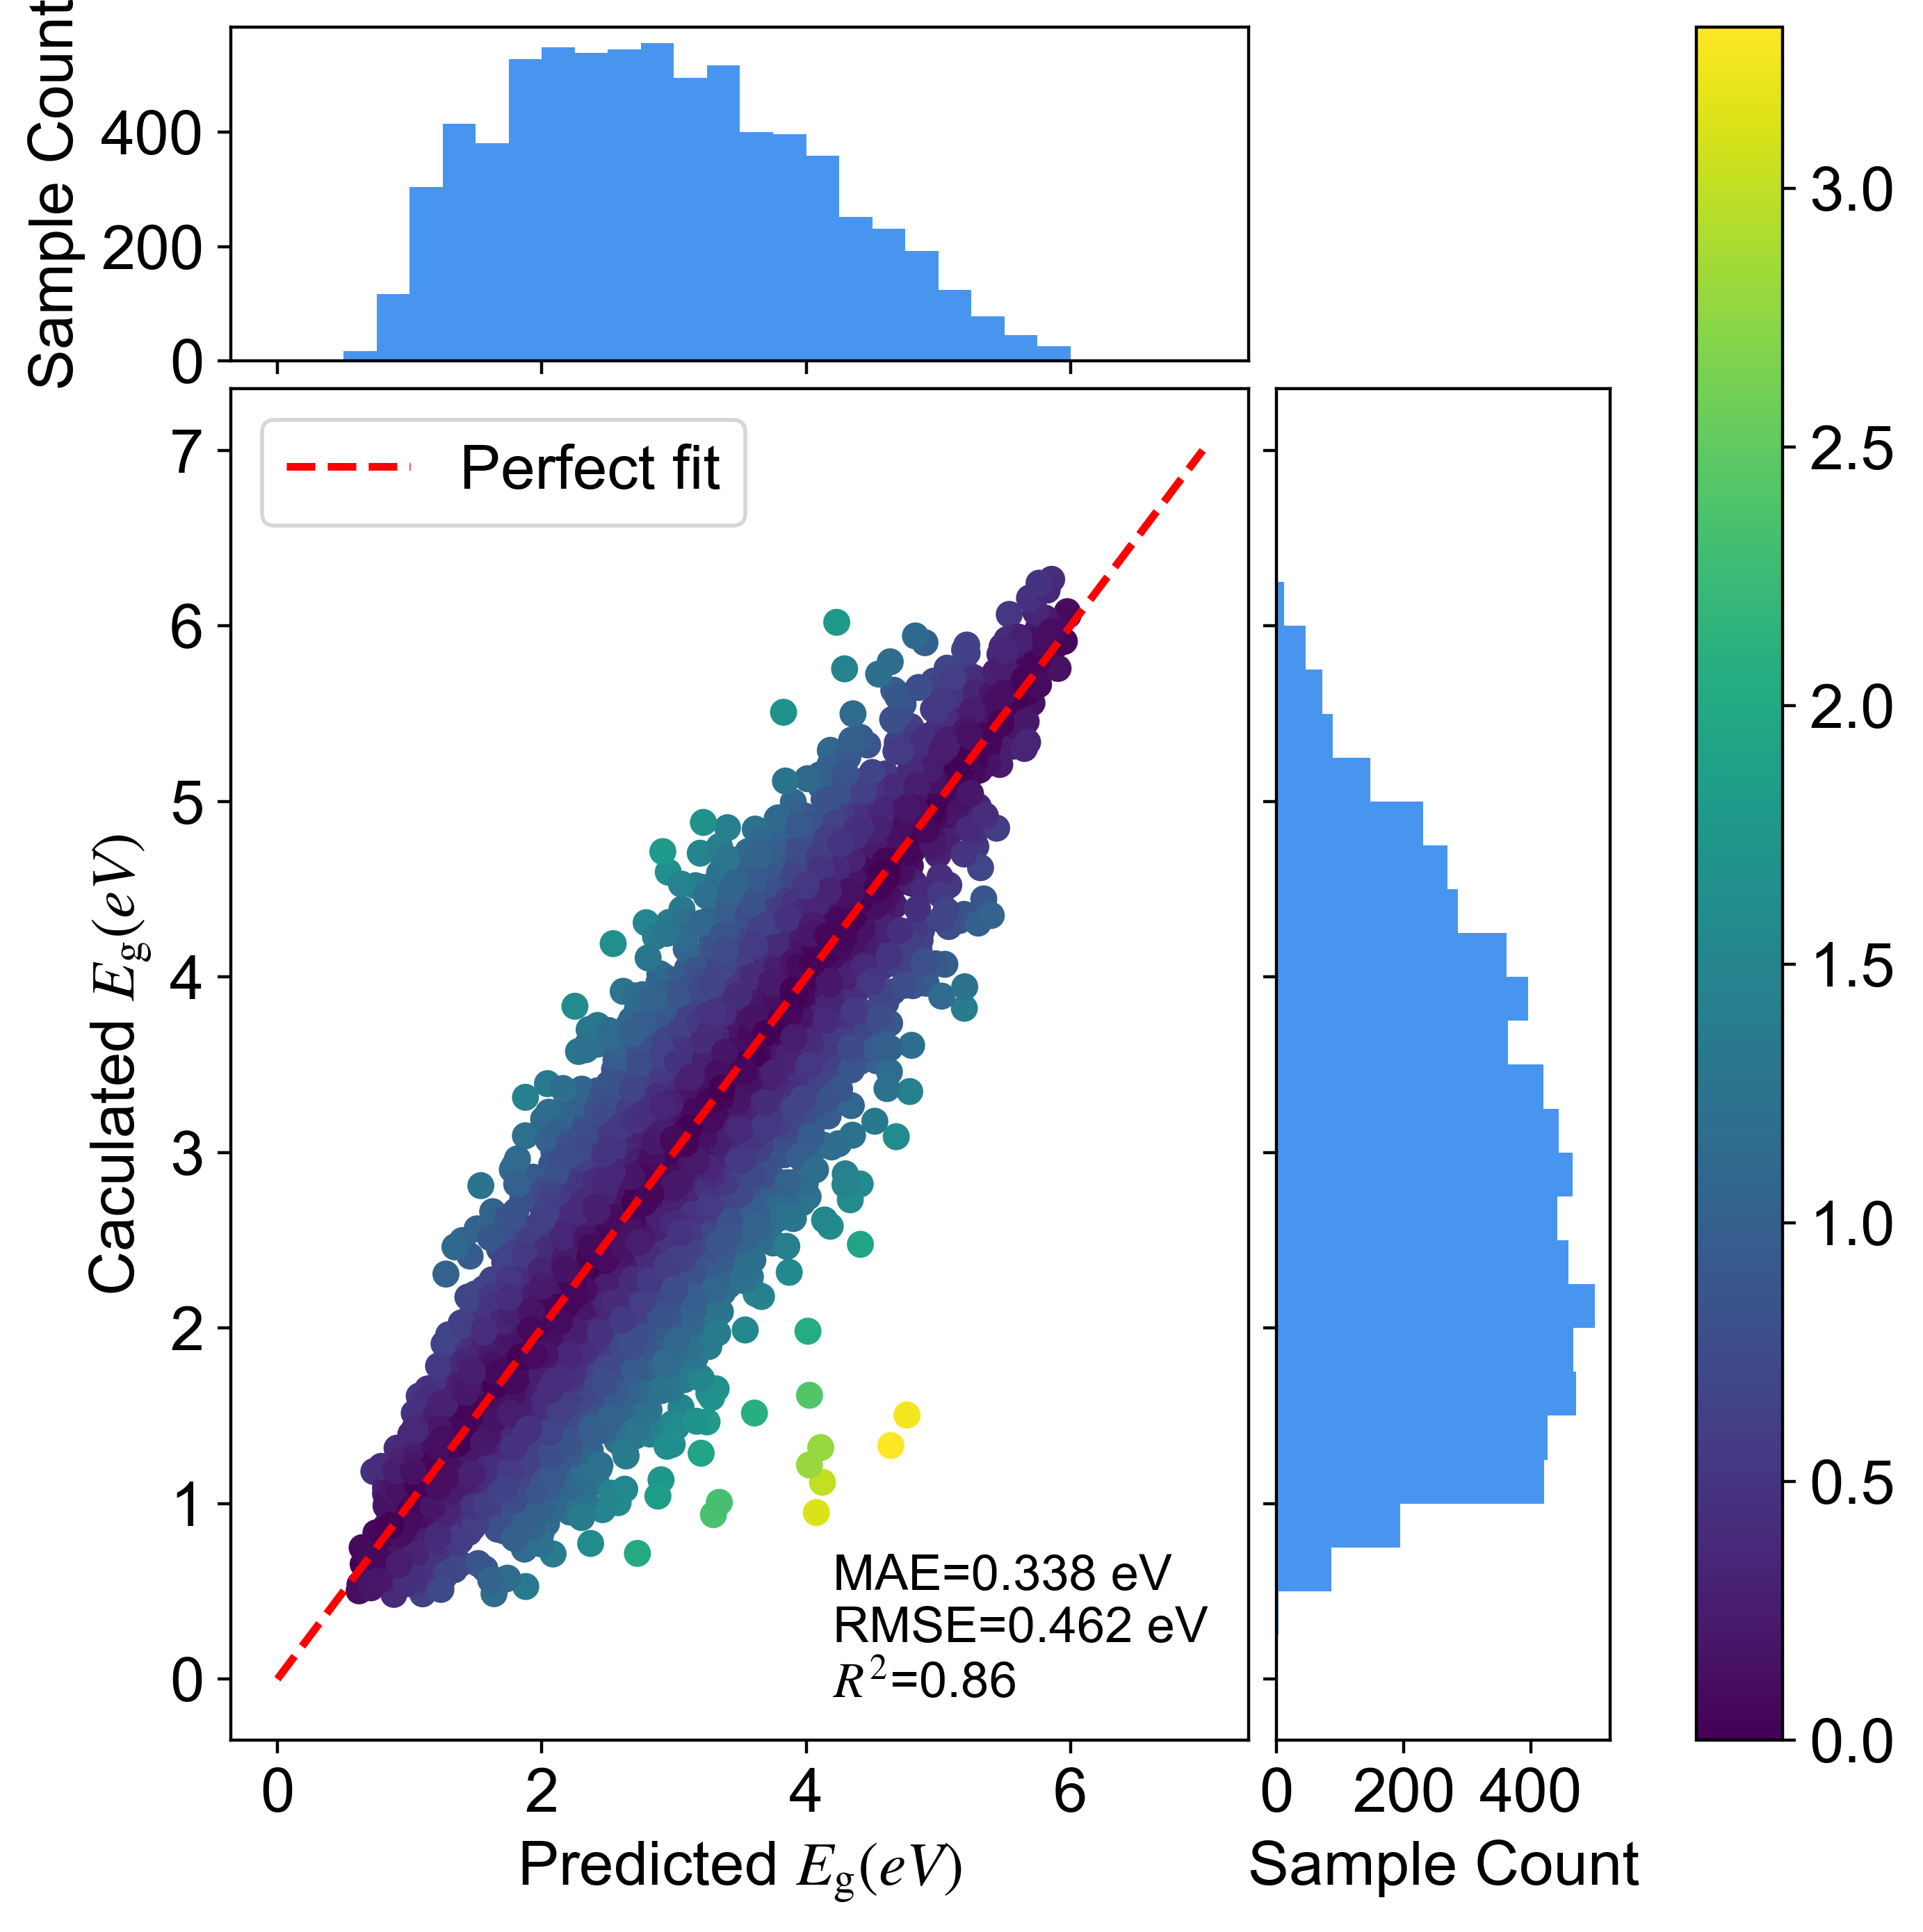

In [28]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
# sns.reset_orig()
fig,ax = plt.subplots(figsize=(8,8),facecolor="w")
sc = ax.scatter(y_pred,best_y_test,c=abs(best_y_test-y_pred))
cbar = fig.colorbar(sc)

ax.plot([0, 7], [0, 7], linestyle='--', color='red',lw=2,label='Perfect fit')

ax.legend()

model_result = "MAE=0.338 eV\nRMSE=0.462 eV\n$ R^{\mathrm{2}}$=0.86"
ax.text(4.2,-0.1,model_result,fontsize=13,bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

ax.set_xlabel('Predicted '+r'$E_{\mathrm{g}}(eV)$')
ax.set_ylabel('Caculated '+ r'$E_{\mathrm{g}} (eV)$')

# Set aspect of the main Axes.


# create new Axes on the right and on the top of the current Axes
divider = make_axes_locatable(ax)
# below height and pad are in inches
ax_histx = divider.append_axes("top", 1.2, pad=0.1, sharex=ax)
ax_histy = divider.append_axes("right", 1.2, pad=0.1, sharey=ax)


# # make some labels invisible
ax_histx.xaxis.set_tick_params(labelbottom=False)
ax_histy.yaxis.set_tick_params(labelleft=False)

binwidth = 0.25
xymax = max(np.max(np.abs(y_pred)), np.max(np.abs(best_y_test)))
lim = (int(xymax/binwidth) + 1)*binwidth

bins = np.arange(0, lim + binwidth, binwidth)
ax_histx.hist(y_pred, bins=bins,color='#4895ef')
ax_histy.hist(best_y_test, bins=bins, orientation='horizontal',color='#4895ef')



ax_histx.set_yticks([0, 200, 400])
ax_histy.set_xticks([0, 200, 400])

ax_histx.set_ylabel('Sample Count')
ax_histy.set_xlabel('Sample Count')

plt.show()

In [29]:
def get_latex_feature_names(data):
    name_dict = {"A_covalent Radius": r'$ A^{\mathrm{CR}}$',
                 'A_Density':r'$ A^{\mathrm{D}}$',
                 'B_Density':r'$ B^{\mathrm{D}}$',
                 'A_Period': r'$ A^{\mathrm{P}}$',
                 'B_Period': r'$ B^{\mathrm{P}}$',
                 'A_number of Valence Electrons':r'$ A^{\mathrm{VE}}$',
                 'B_number of Valence Electrons':r'$ B^{\mathrm{VE}}$',
                 'A_number of d Electrons':r'$ A^{\mathrm{d}}$',
                 'B_number of d Electrons':r'$ B^{\mathrm{d}}$',
                 'A_Electronegativity':r'$ A^{\mathrm{En}}$',
                 'B_Electronegativity':r'$ B^{\mathrm{En}}$',
                 'A_Mulliken EN':r'$ A^{\mathrm{MEn}}$',
                 'B_Mulliken EN':r'$ B^{\mathrm{MEn}}$',
                 'B_atomic Radius':r'$ B^{\mathrm{R}}$',
                'A_number of s+p Electrons': r'$ A^{\mathrm{s+p}}$',
                'B_number of s+p Electrons': r'$ B^{\mathrm{s+p}}$',
                 'A-B_Density':r'$ X_\mathrm{1}^{\mathrm{D}}$',
                '(A+B)-O_Density': r'$ X_\mathrm{2}^{\mathrm{D}}$',
                 '(A+B)-O_covalent Radius':r'$ X_\mathrm{2}^{\mathrm{CR}}$',
                 'A-B_covalent Radius':r'$ X_\mathrm{1}^{\mathrm{CR}}$',
                 '(A+B)-O_number of Valence Electrons':r'$ X_\mathrm{2}^{\mathrm{VE}}$',
                 'A-B_Electronegativity':r'$ X_\mathrm{1}^{\mathrm{En}}$',
                 'A-B_number of Valence Electrons':r'$ X_\mathrm{1}^{\mathrm{VE}}$',
                 'A-B_number':r'$ X_\mathrm{1}^{\mathrm{N}}$',
                 '(A+B)-O_Electronegativity':r'$ X_\mathrm{2}^{\mathrm{En}}$',
                 'A-B_number of d Electrons':r'$X_\mathrm{1}^{\mathrm{d}}$',
                 'A-B_number of s+p Electrons':r'$ X_\mathrm{1}^{\mathrm{s+p}}$',
                 '(A+B)-O_number of s+p Electrons':r'$ X_\mathrm{2}^{\mathrm{s+p}}$',
                 '(A+B)-O_number of d Electrons':r'$ X_\mathrm{2}^{\mathrm{d}}$',
                 '(A+B)-O_Period':r'$ X_\mathrm{2}^{\mathrm{P}}$',
                 'A-B_FirstIonization':r'$ X_\mathrm{2}^{\mathrm{FI}}$',
                 'B_atomic_hfomo':r'$ B^{\mathrm{hfomo}}$',
                 'B_atomic_lpumo':r'$ B^{\mathrm{lpumo}}$',
                 'B_atomic_r_val_neg_1':r'$ B_\mathrm{-1}^{\mathrm{Rval}}$',
                 'A_atomic_ndval':r'$ A^{\mathrm{ndval}}$',
                 'B_atomic_npval':r'$ B^{\mathrm{npval}}$',
                 'A_atomic_nunf':r'$ A^{\mathrm{nunf}}$',
                 'A_atomic_nfunf':r'$ A^{\mathrm{nfunf}}$',
                 'B_atomic_r_val_05':r'$ B_\mathrm{05}^{\mathrm{Rval}}$',
                 'B_atomic_ndval':r'$ B^{\mathrm{ndval}}$',
                 'A_atomic_r_val':r'$ A^{\mathrm{Rval}}$',
                 'A_atomic_nfval':r'$ A^{\mathrm{nfval}}$',
                 'A_atomic_ea':r'$ A^{\mathrm{EA}}$',
                 'A_atomic_lfumo':r'$ A^{\mathrm{lfumo}}$',
                 'A_atomic_r_d_1':r'$ A_\mathrm{1}^{\mathrm{Rd}}$',
                 'A_atomic_r_val_1':r'$ A_\mathrm{1}^{\mathrm{Rval}}$'
                }
    element_dict = {}
    for name in data.columns:
        if '_' not in name and len(name)<=2 :
            element_dict[name] = fr'${name}$'
    name_dict.update(element_dict)
    data = data.rename(columns=name_dict)
    return data

In [30]:
best_X_train = get_latex_feature_names(best_X_train)
best_X_test = get_latex_feature_names(best_X_test)

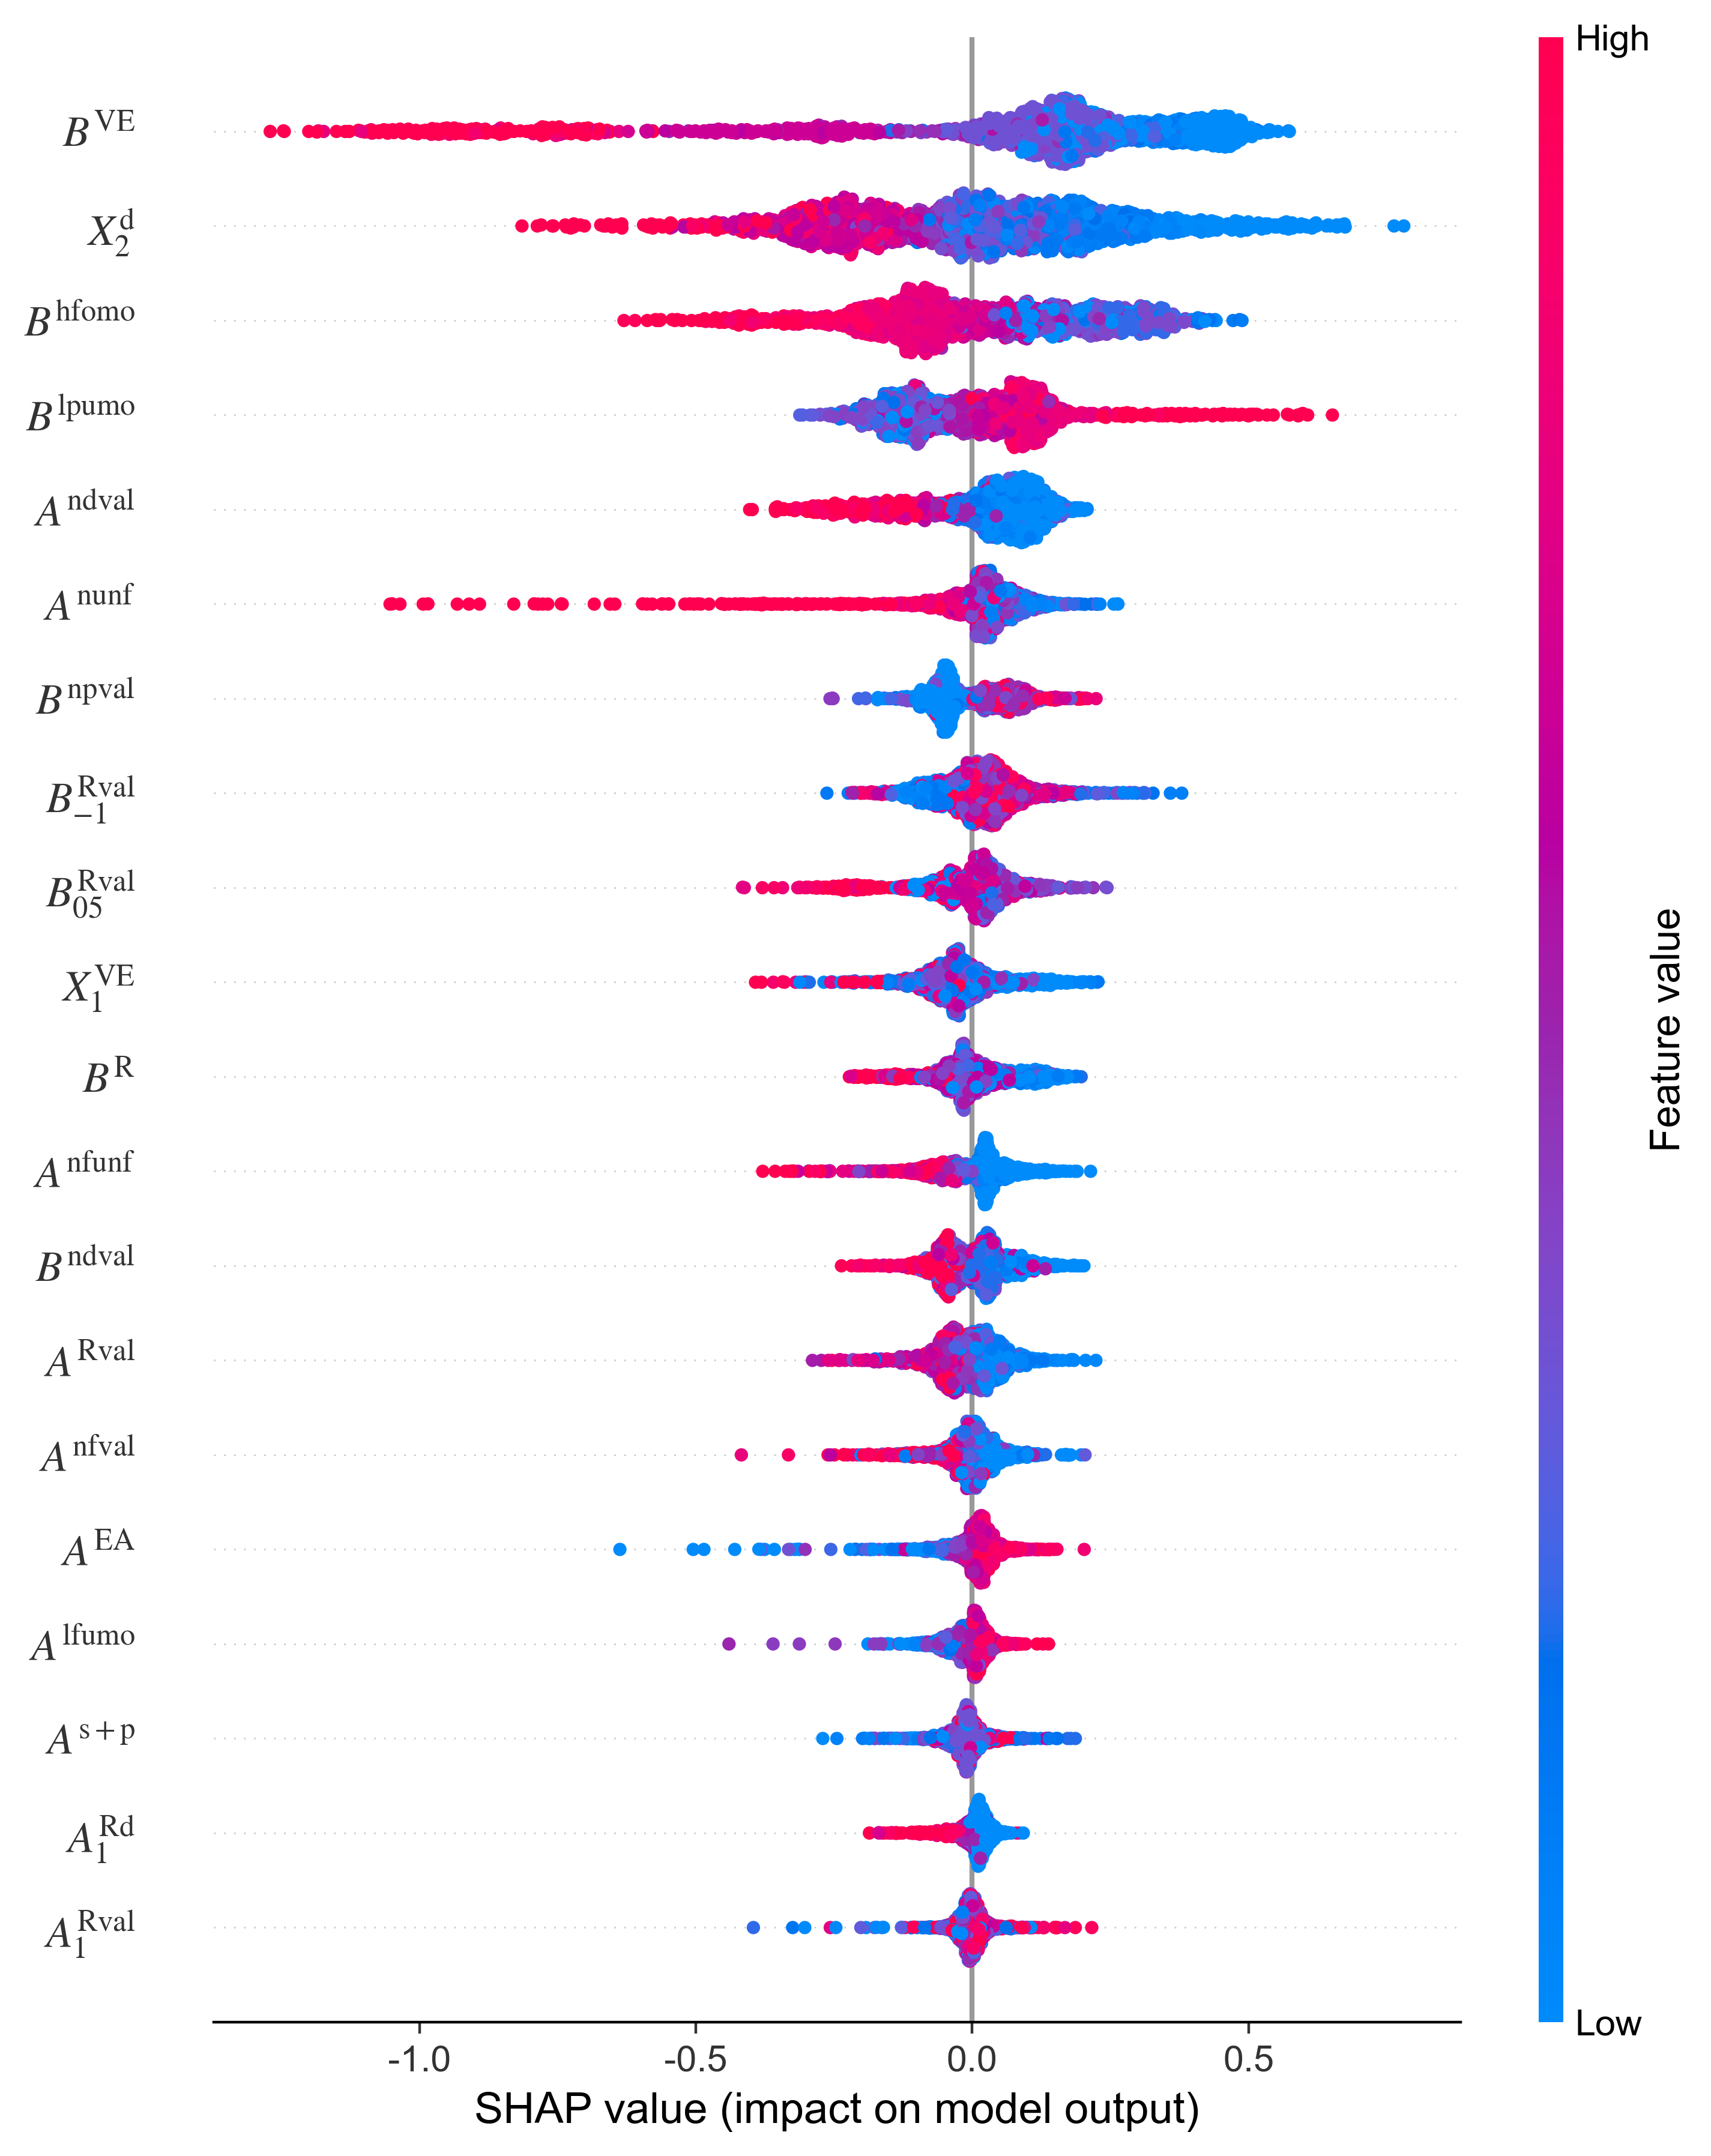

NameError: name 'shap_values' is not defined

In [32]:
import shap
from concurrent.futures import ThreadPoolExecutor, as_completed
explainer = shap.TreeExplainer(model_4)
test = best_X_test.sample(2000)

shap_explanation = explainer(test) 

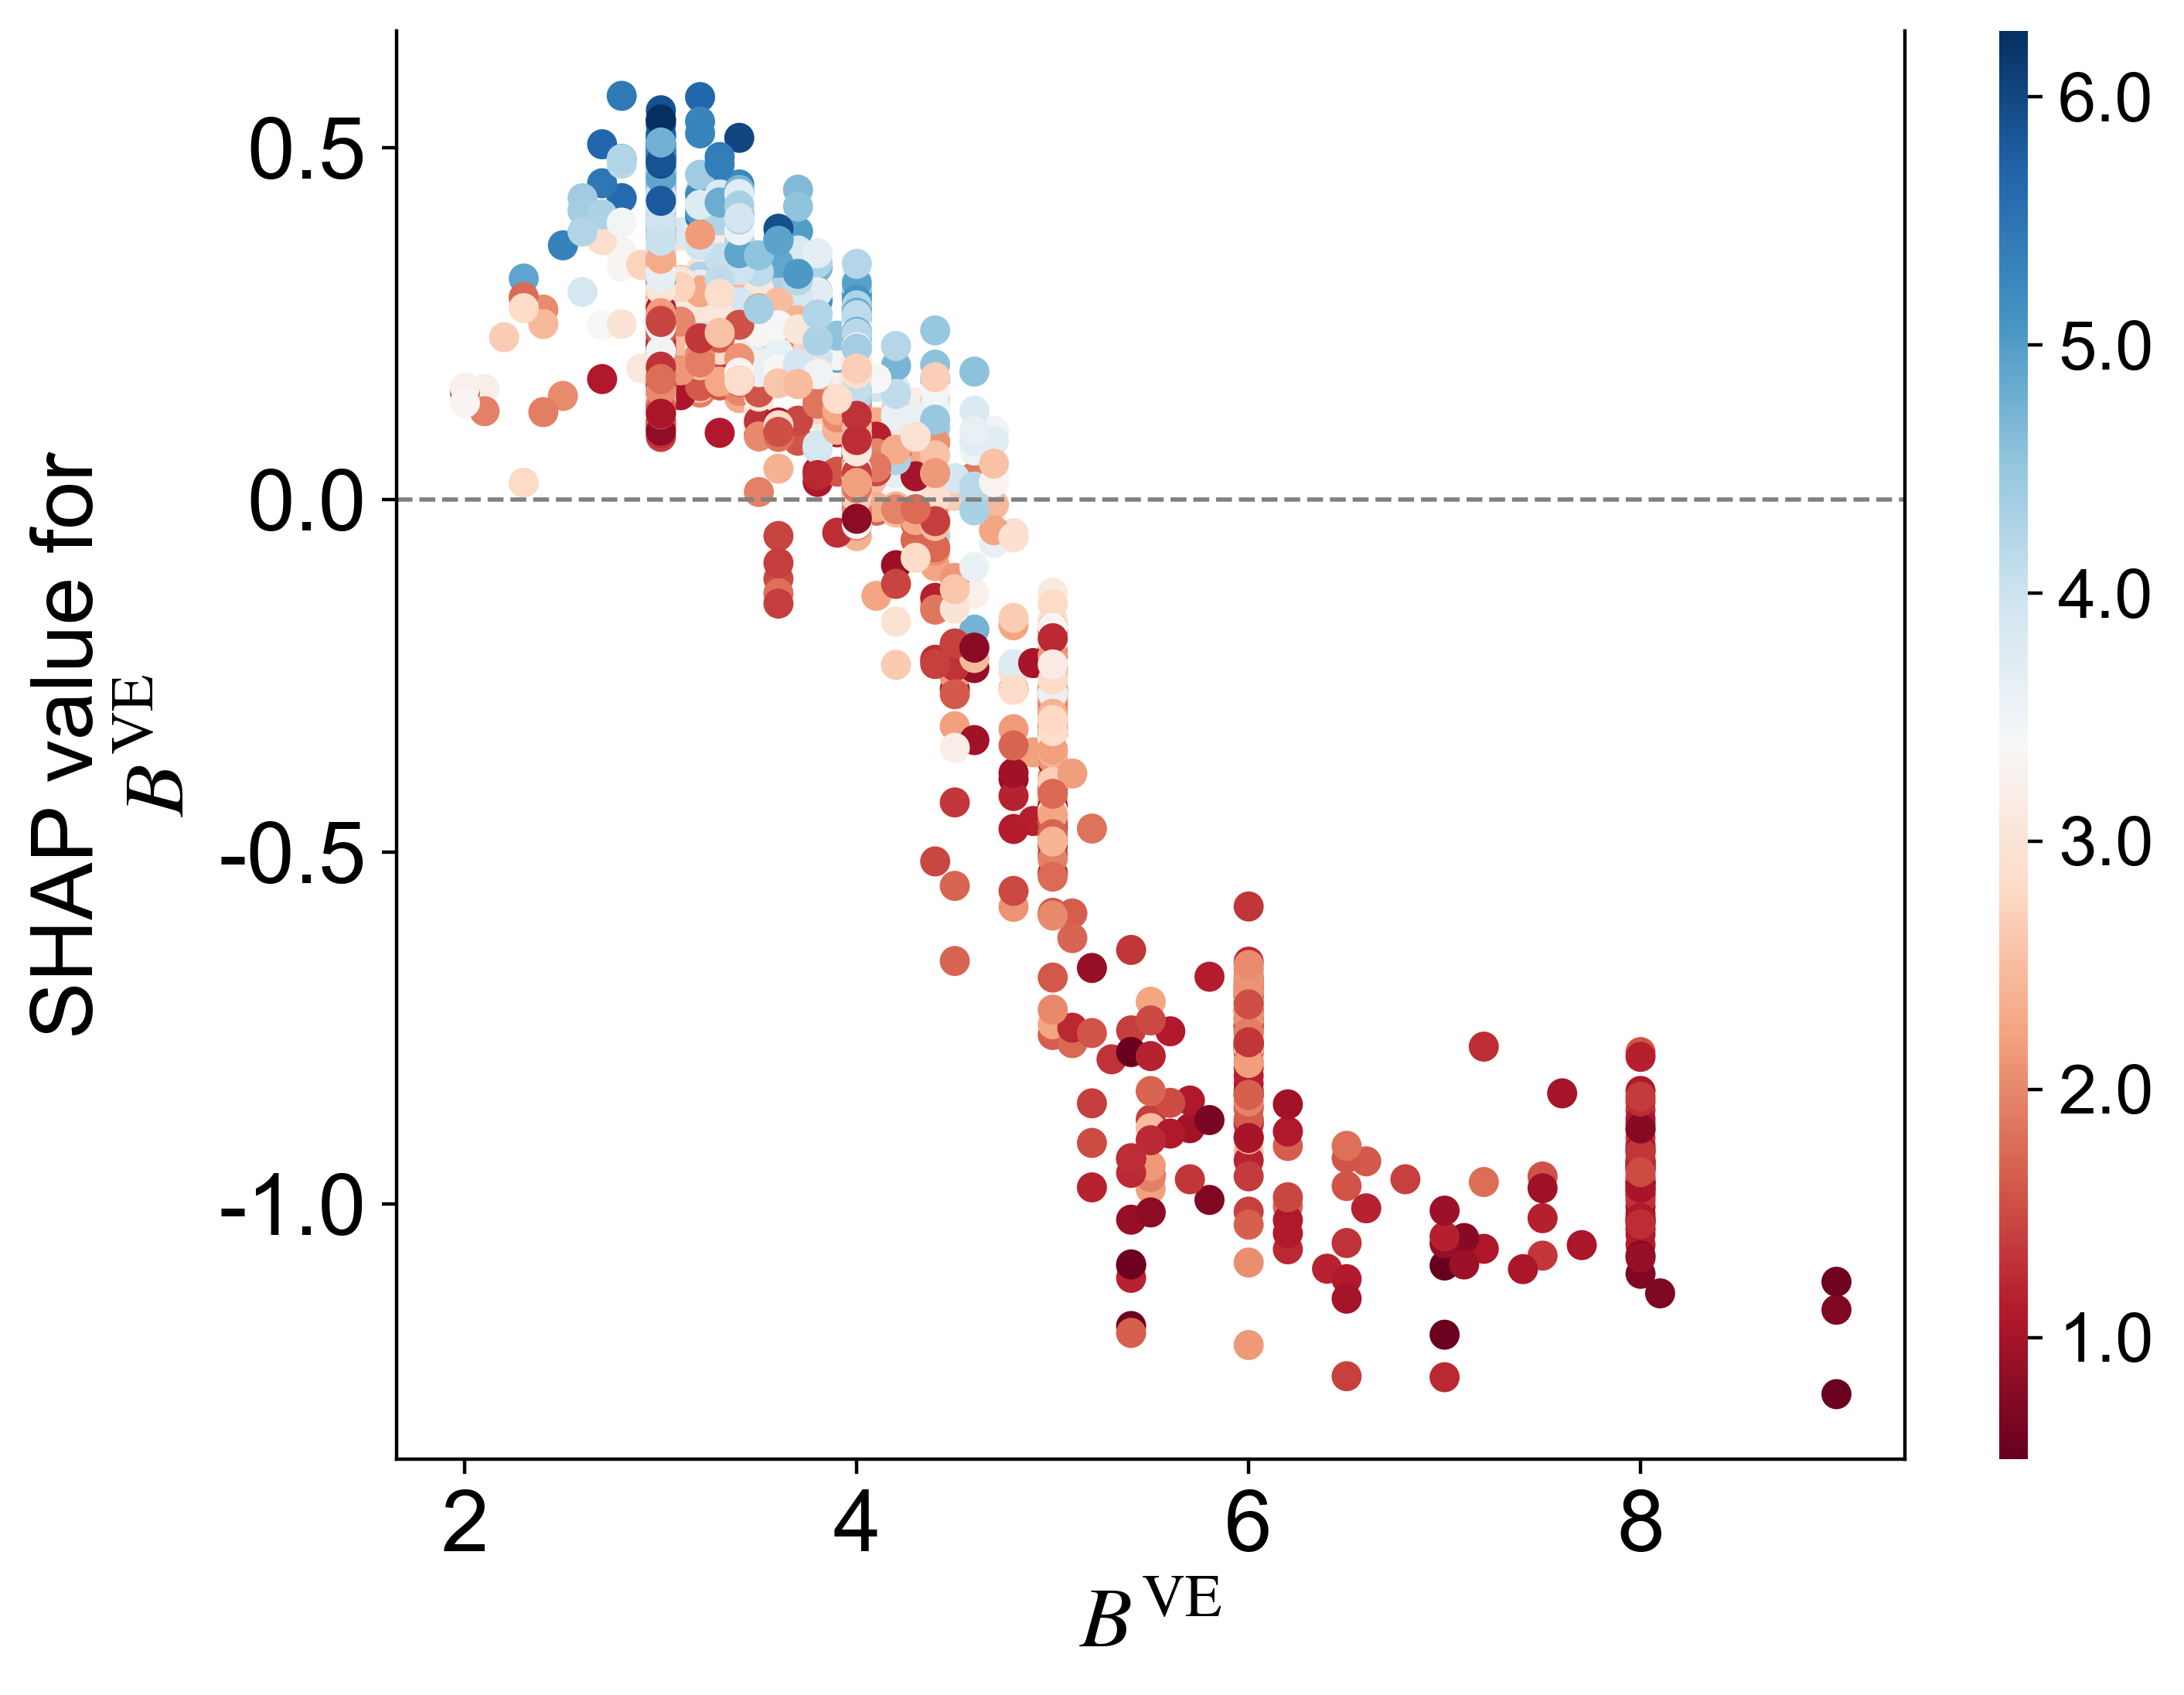

In [126]:
fig, ax = plt.subplots(tight_layout=True, figsize=(8, 6))

# or you need more flexible customization
scatter = ax.scatter(
    shap_explanation[:, '$ B^{\mathrm{VE}}$'].data,
    shap_explanation[:, '$ B^{\mathrm{VE}}$'].values,
    c=best_y_test[test.index].values,
    cmap = "RdBu",
    marker="o",
    rasterized=True,
    zorder=0,
)

cbar = plt.colorbar(scatter, aspect=50, format="%2.1f")
cbar.outline.set_visible(False)

ax.set_xlabel('$ B^{\mathrm{VE}}$', fontsize=20)
ax.set_ylabel("SHAP value for\n$ B^{\mathrm{VE}}$", fontsize=20)
ax.tick_params(labelsize=20)

ax.grid(False)            
ax.spines['top'].set_visible(False)   


ax.axhline(y=0, color='gray', linestyle='--', linewidth=1, zorder=0)
plt.savefig("BVE_shp.png", format='png', dpi=400, bbox_inches='tight')
plt.show()

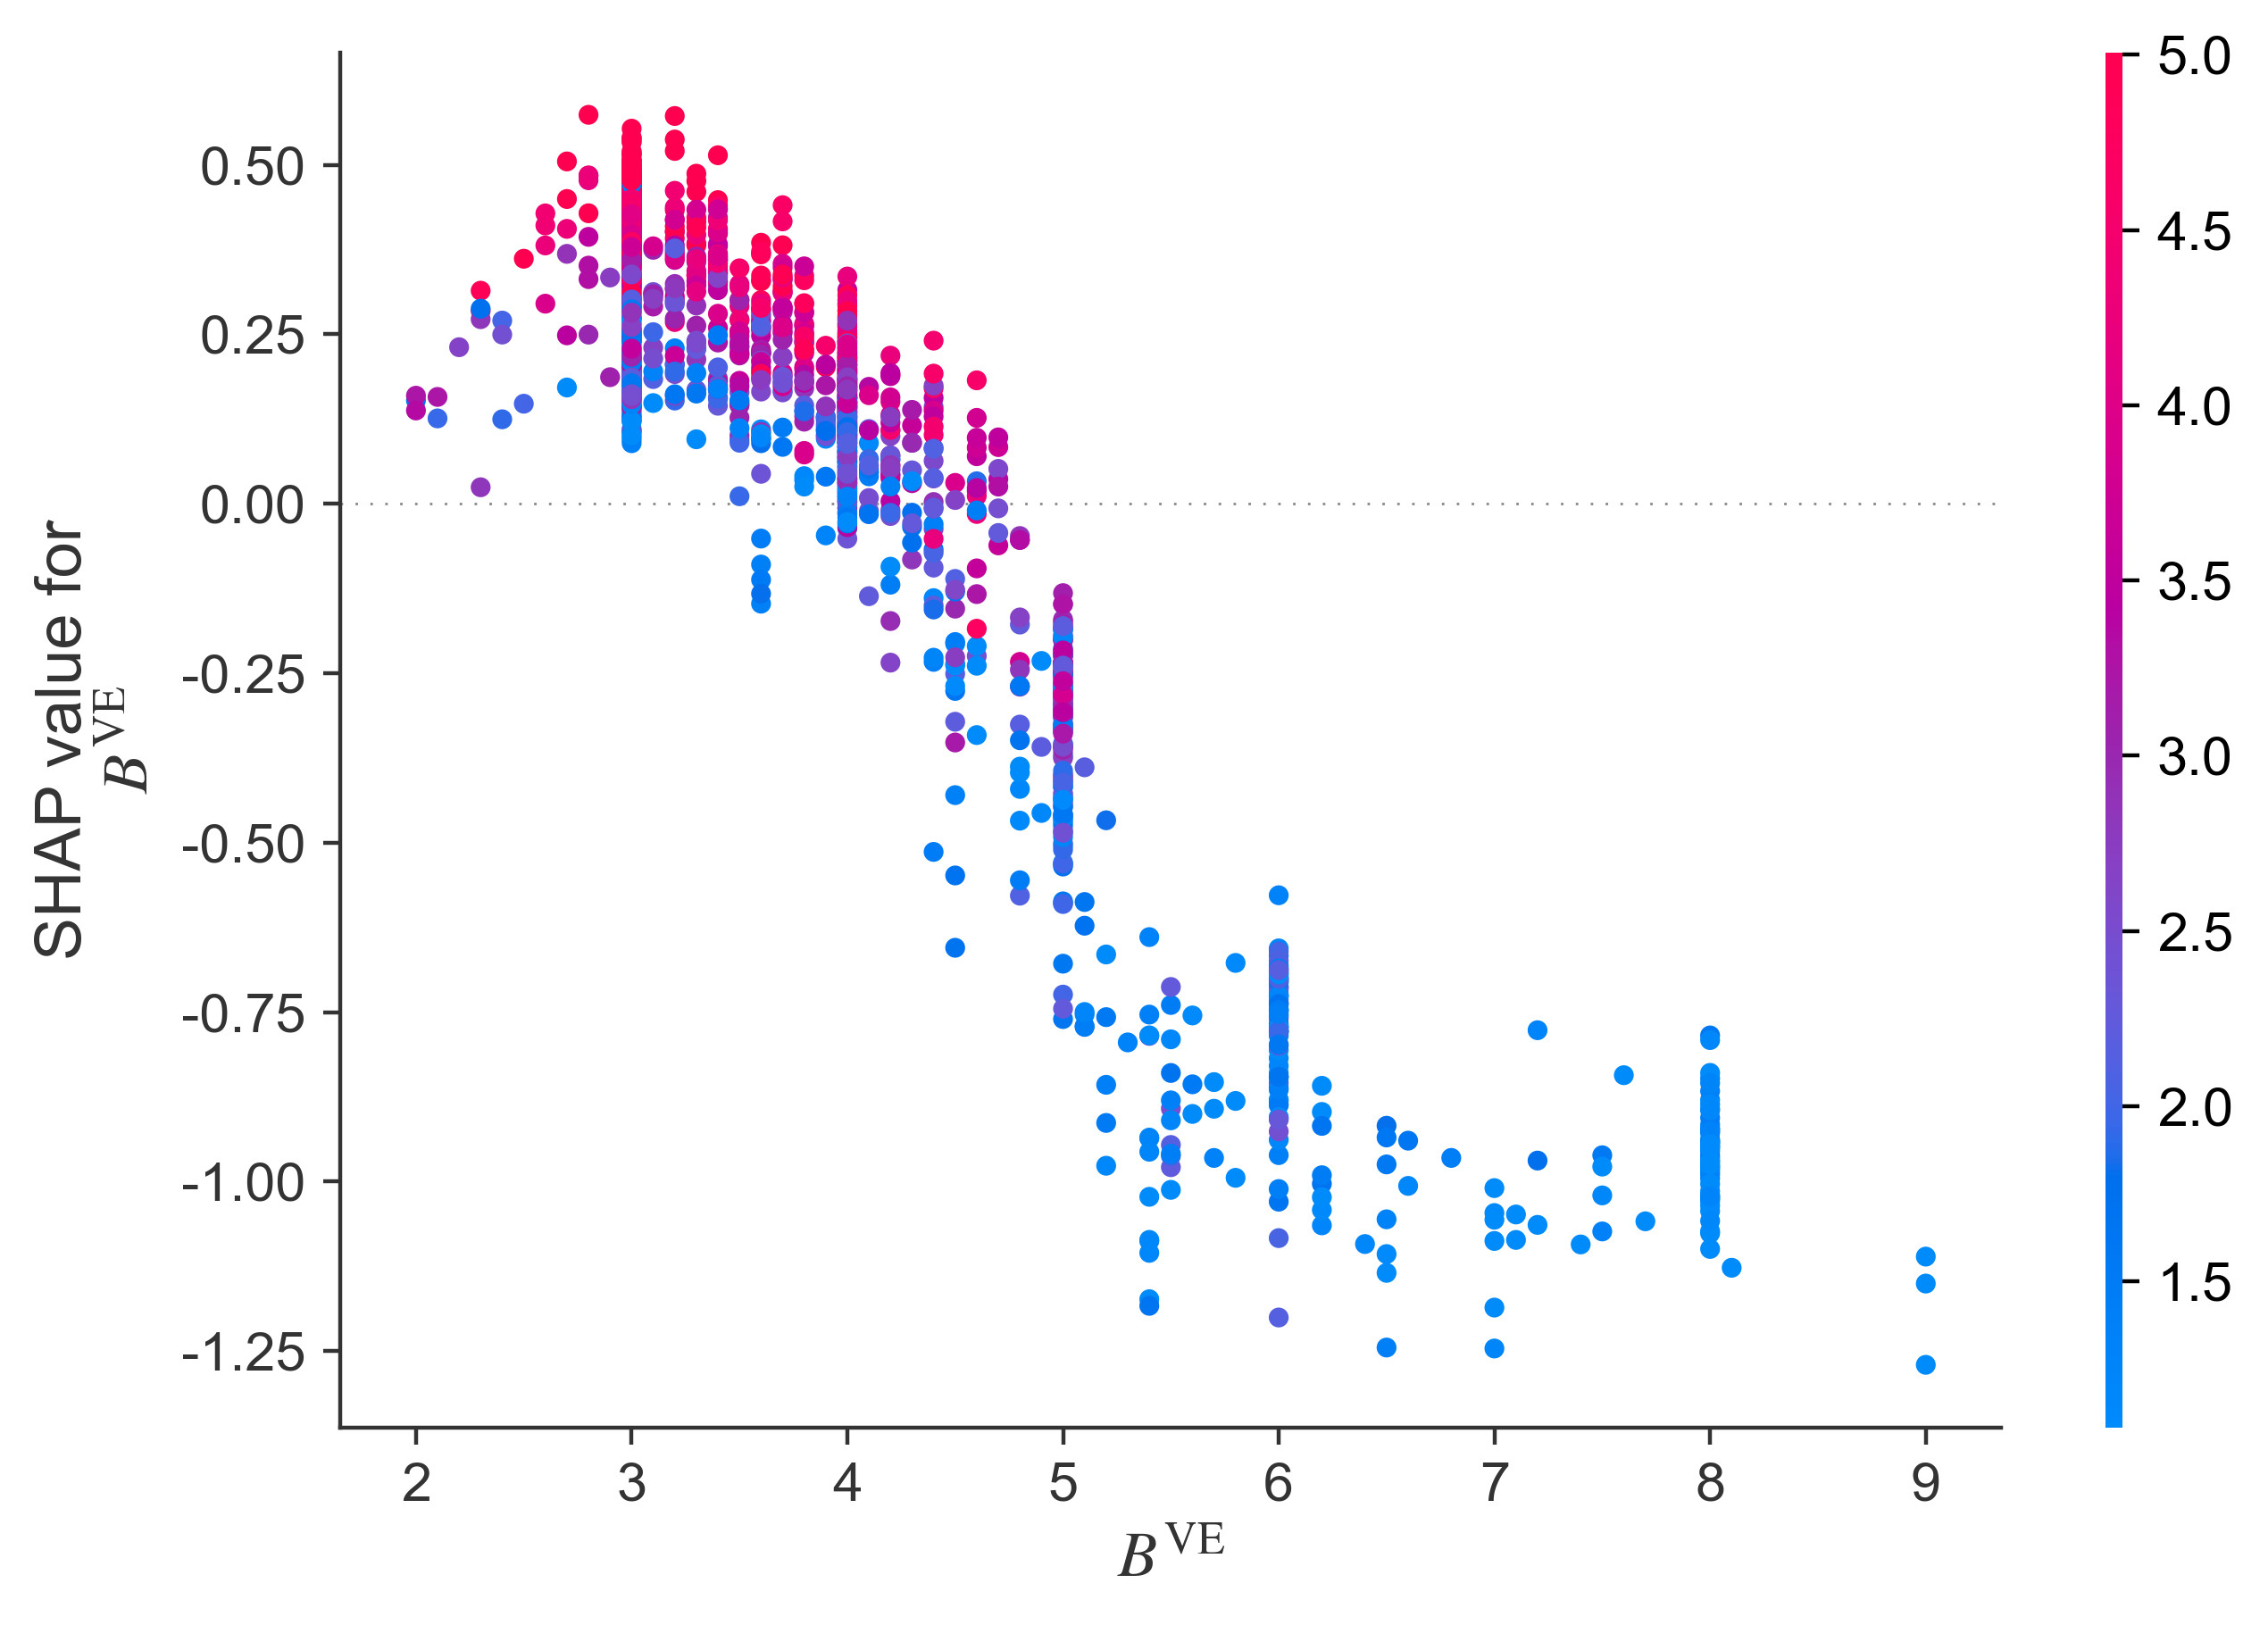

<Figure size 3200x2400 with 0 Axes>

In [101]:
shap.plots.scatter(shap_explanation[:, '$ B^{\mathrm{VE}}$'], color=best_y_test[test.index].values,hist=False)
plt.savefig("BVE_shp.png", format='png', dpi=400, bbox_inches='tight')

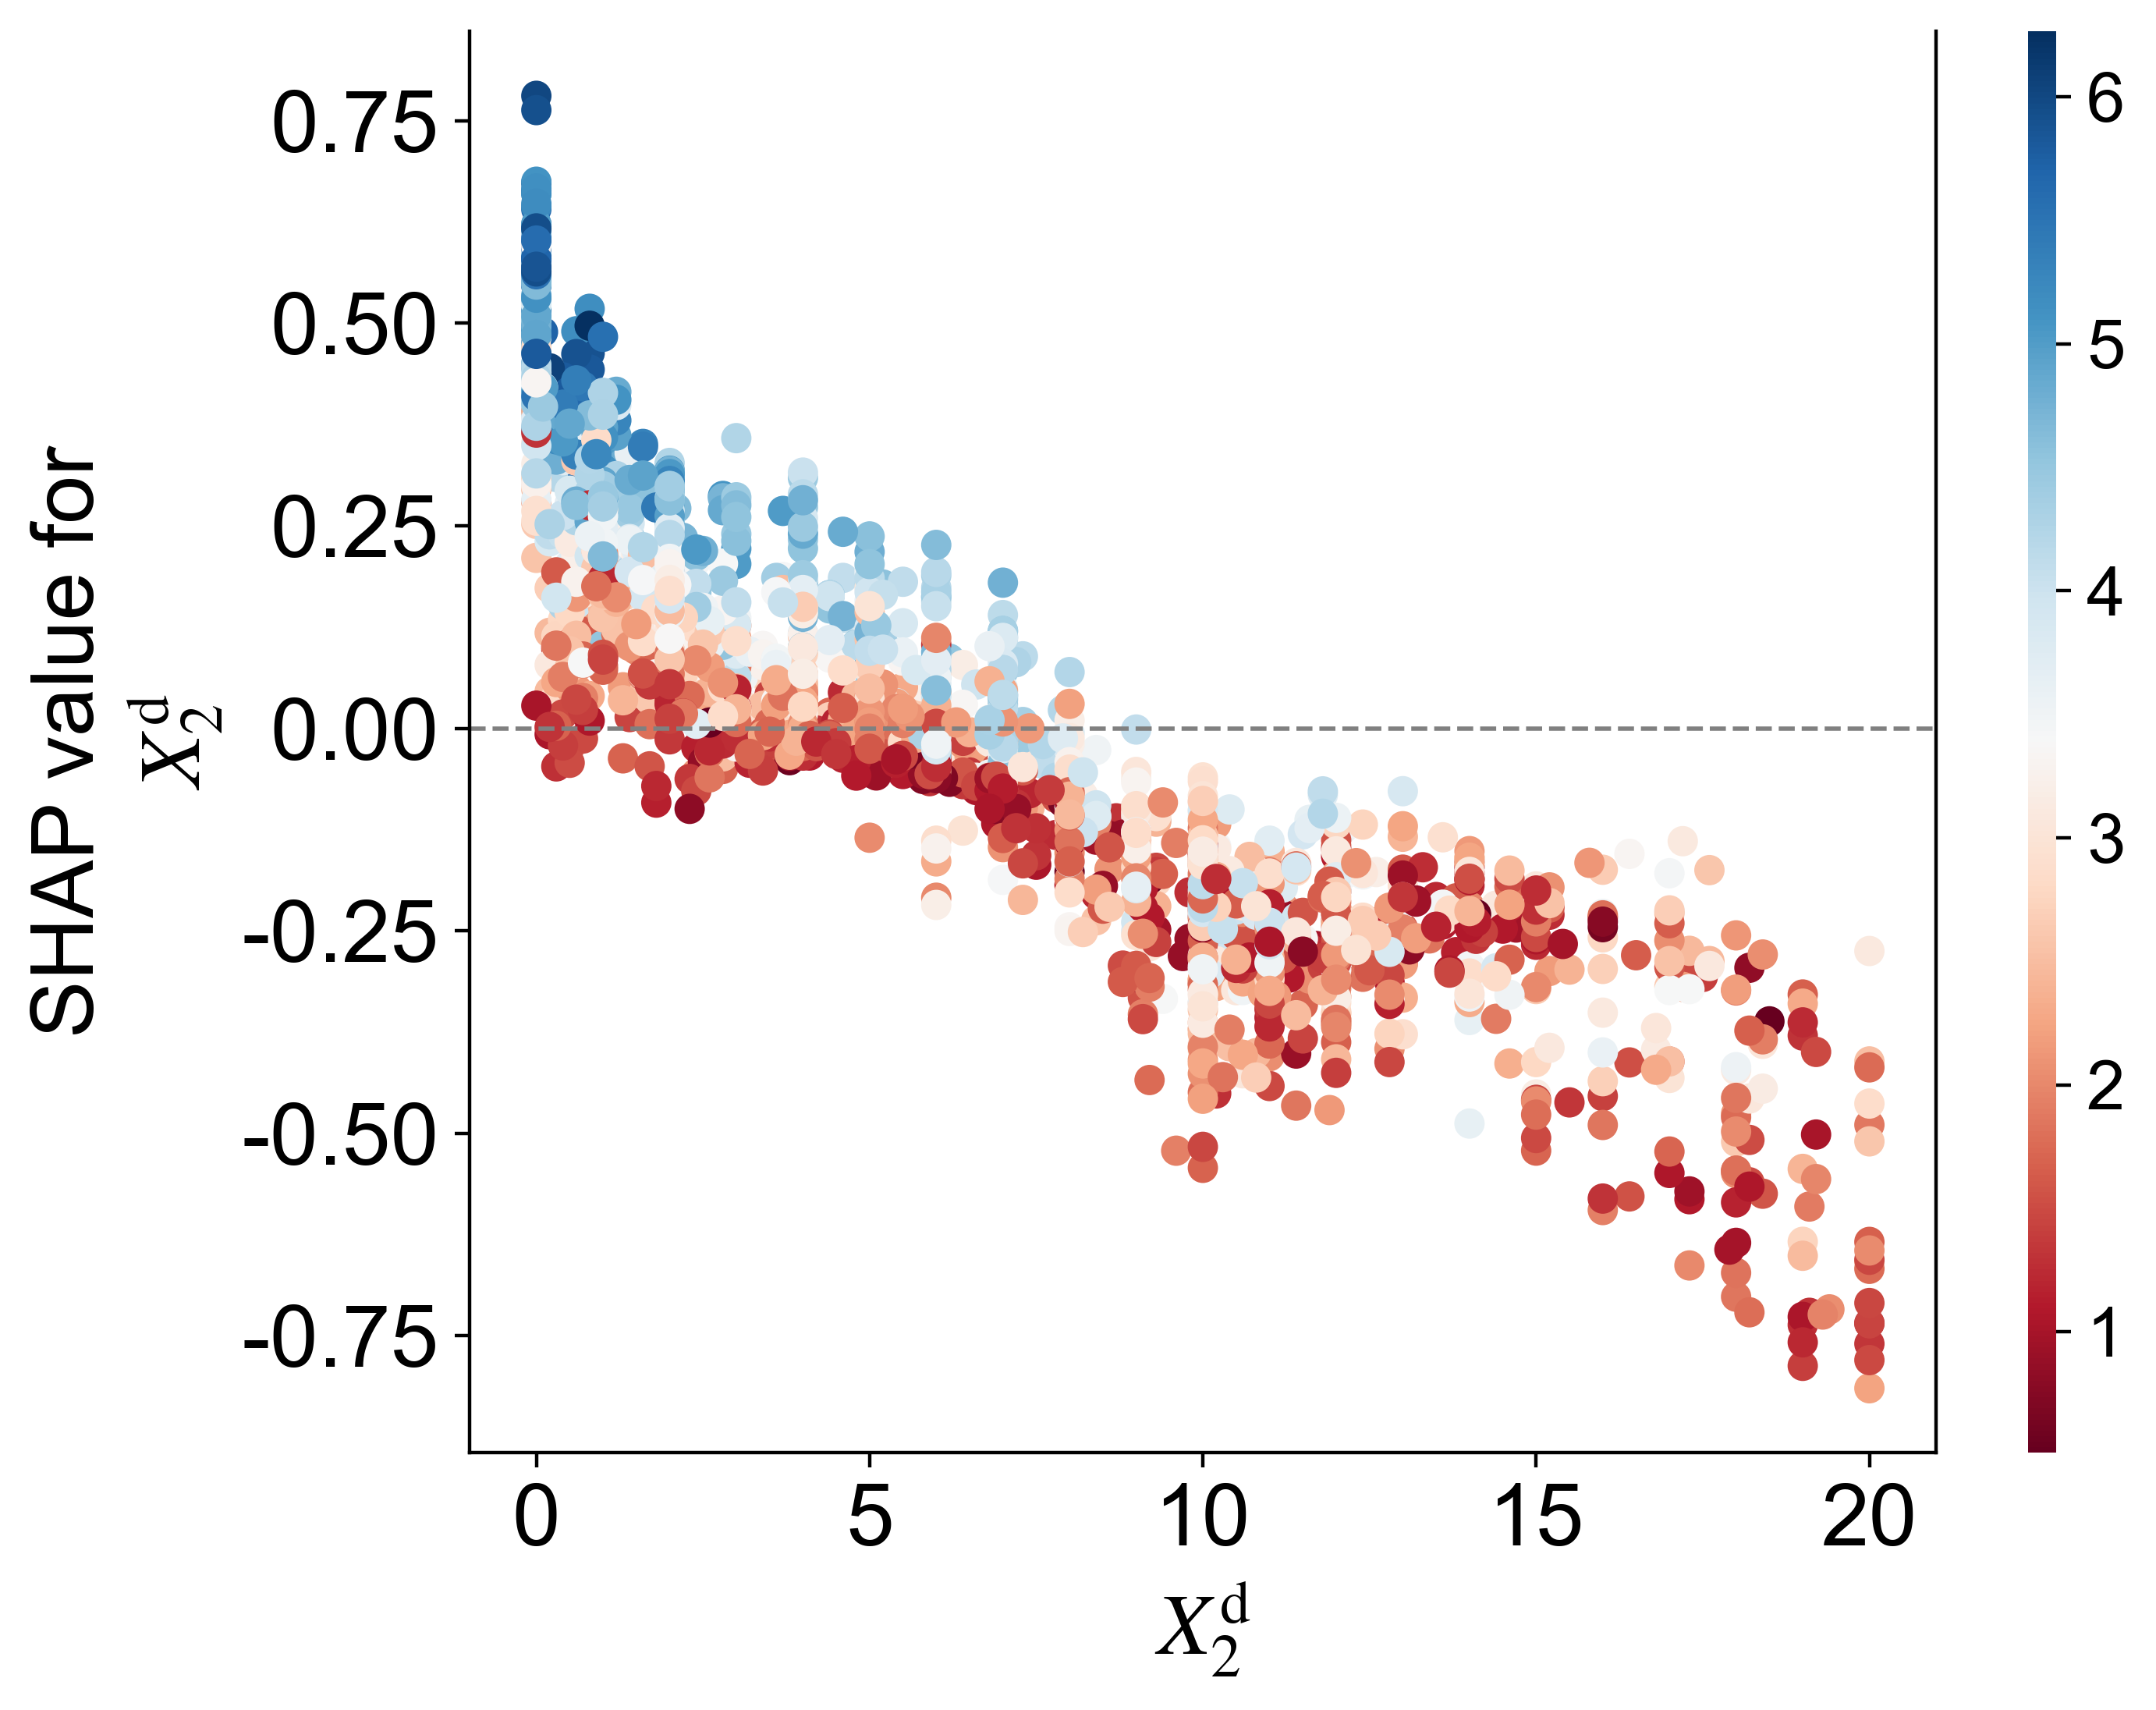

In [128]:
fig, ax = plt.subplots(tight_layout=True, figsize=(8, 6))

# or you need more flexible customization
scatter = ax.scatter(
    shap_explanation[:, '$ X_\mathrm{2}^{\mathrm{d}}$'].data,
    shap_explanation[:, '$ X_\mathrm{2}^{\mathrm{d}}$'].values,
    c=best_y_test[test.index].values,
    cmap = "RdBu",
    marker="o",
    rasterized=True,
    zorder=0,
)

cbar = plt.colorbar(scatter, aspect=50, format="%.1f")
cbar.outline.set_visible(False)

ax.set_xlabel('$ X_\mathrm{2}^{\mathrm{d}}$', fontsize=20)
ax.set_ylabel("SHAP value for\n$ X_\mathrm{2}^{\mathrm{d}}$", fontsize=20)
ax.tick_params(labelsize=20)

ax.grid(False)             
ax.spines['top'].set_visible(False)   

ax.axhline(y=0, color='gray', linestyle='--', linewidth=1, zorder=0)
plt.savefig("X2D_shp.png", format='png', dpi=400, bbox_inches='tight')
plt.show()

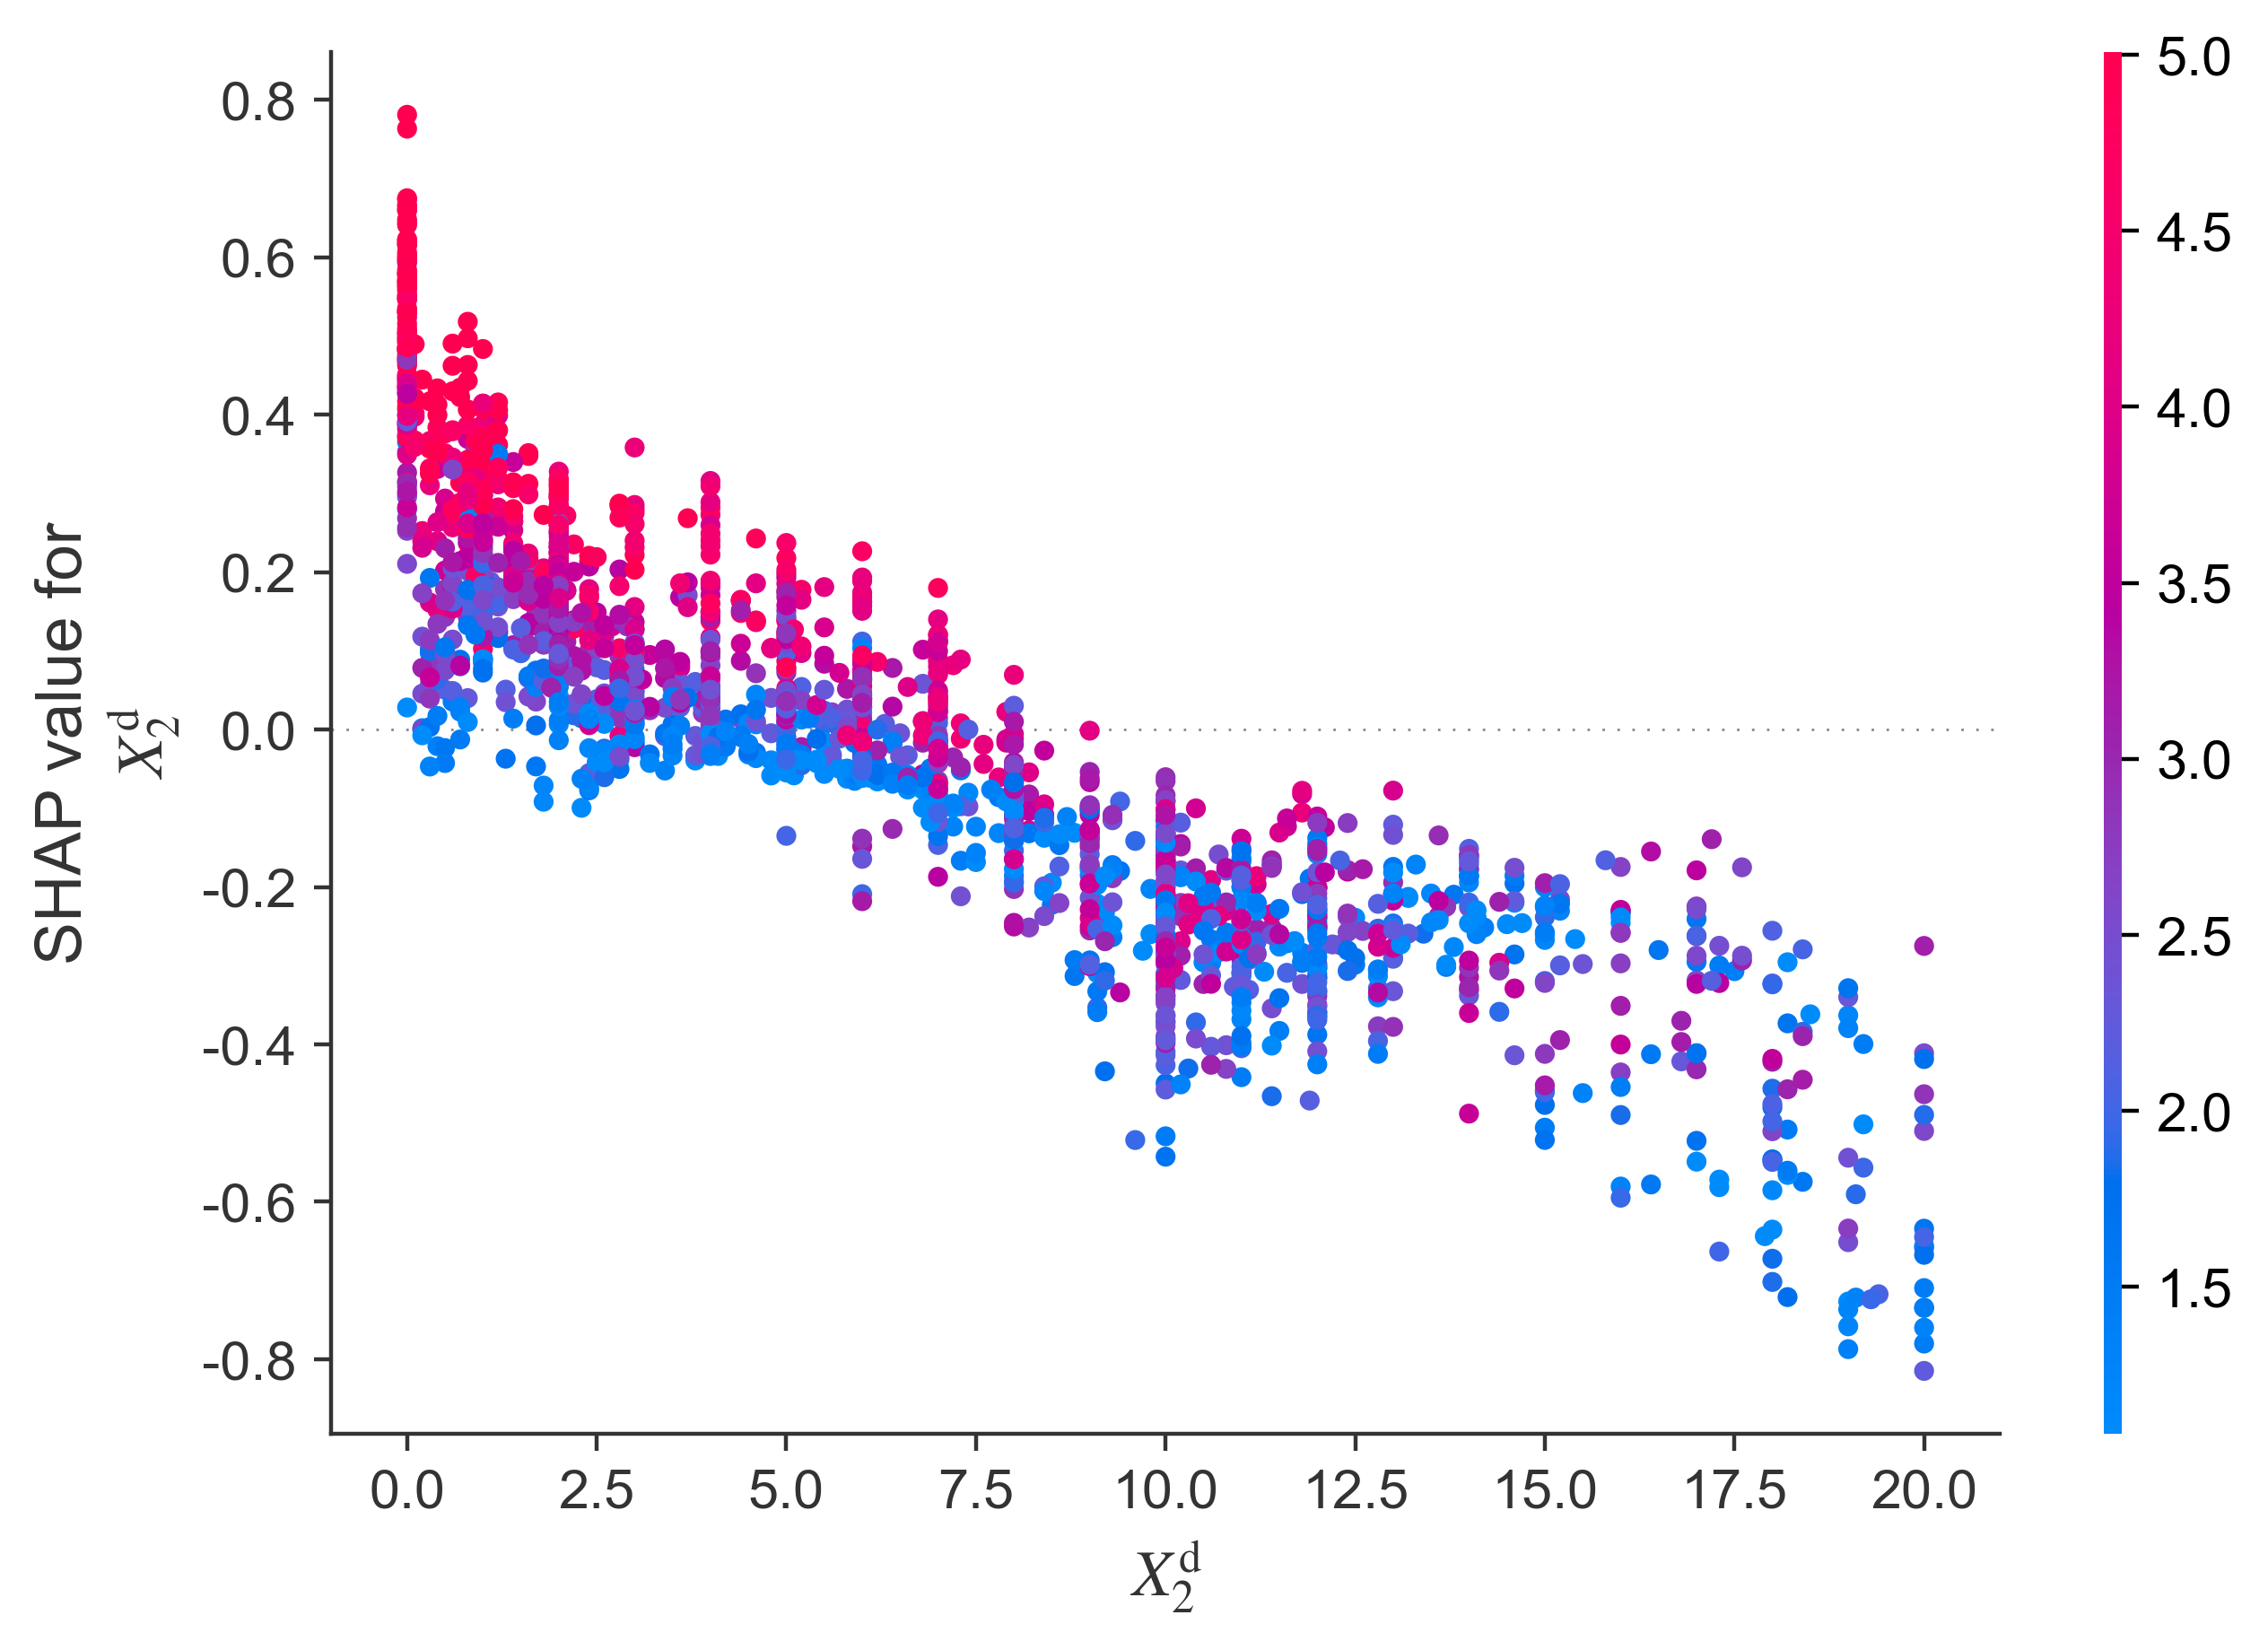

AttributeError: 'NoneType' object has no attribute 'tick_params'

In [102]:
ax = shap.plots.scatter(shap_explanation[:, '$ X_\mathrm{2}^{\mathrm{d}}$'], color=best_y_test[test.index].values,hist = False)
ax.tick_params(axis='both', labelsize=20)    # 同时修改X和Y轴刻度
plt.savefig("X2D_shp.png", format='png', dpi=400, bbox_inches='tight')

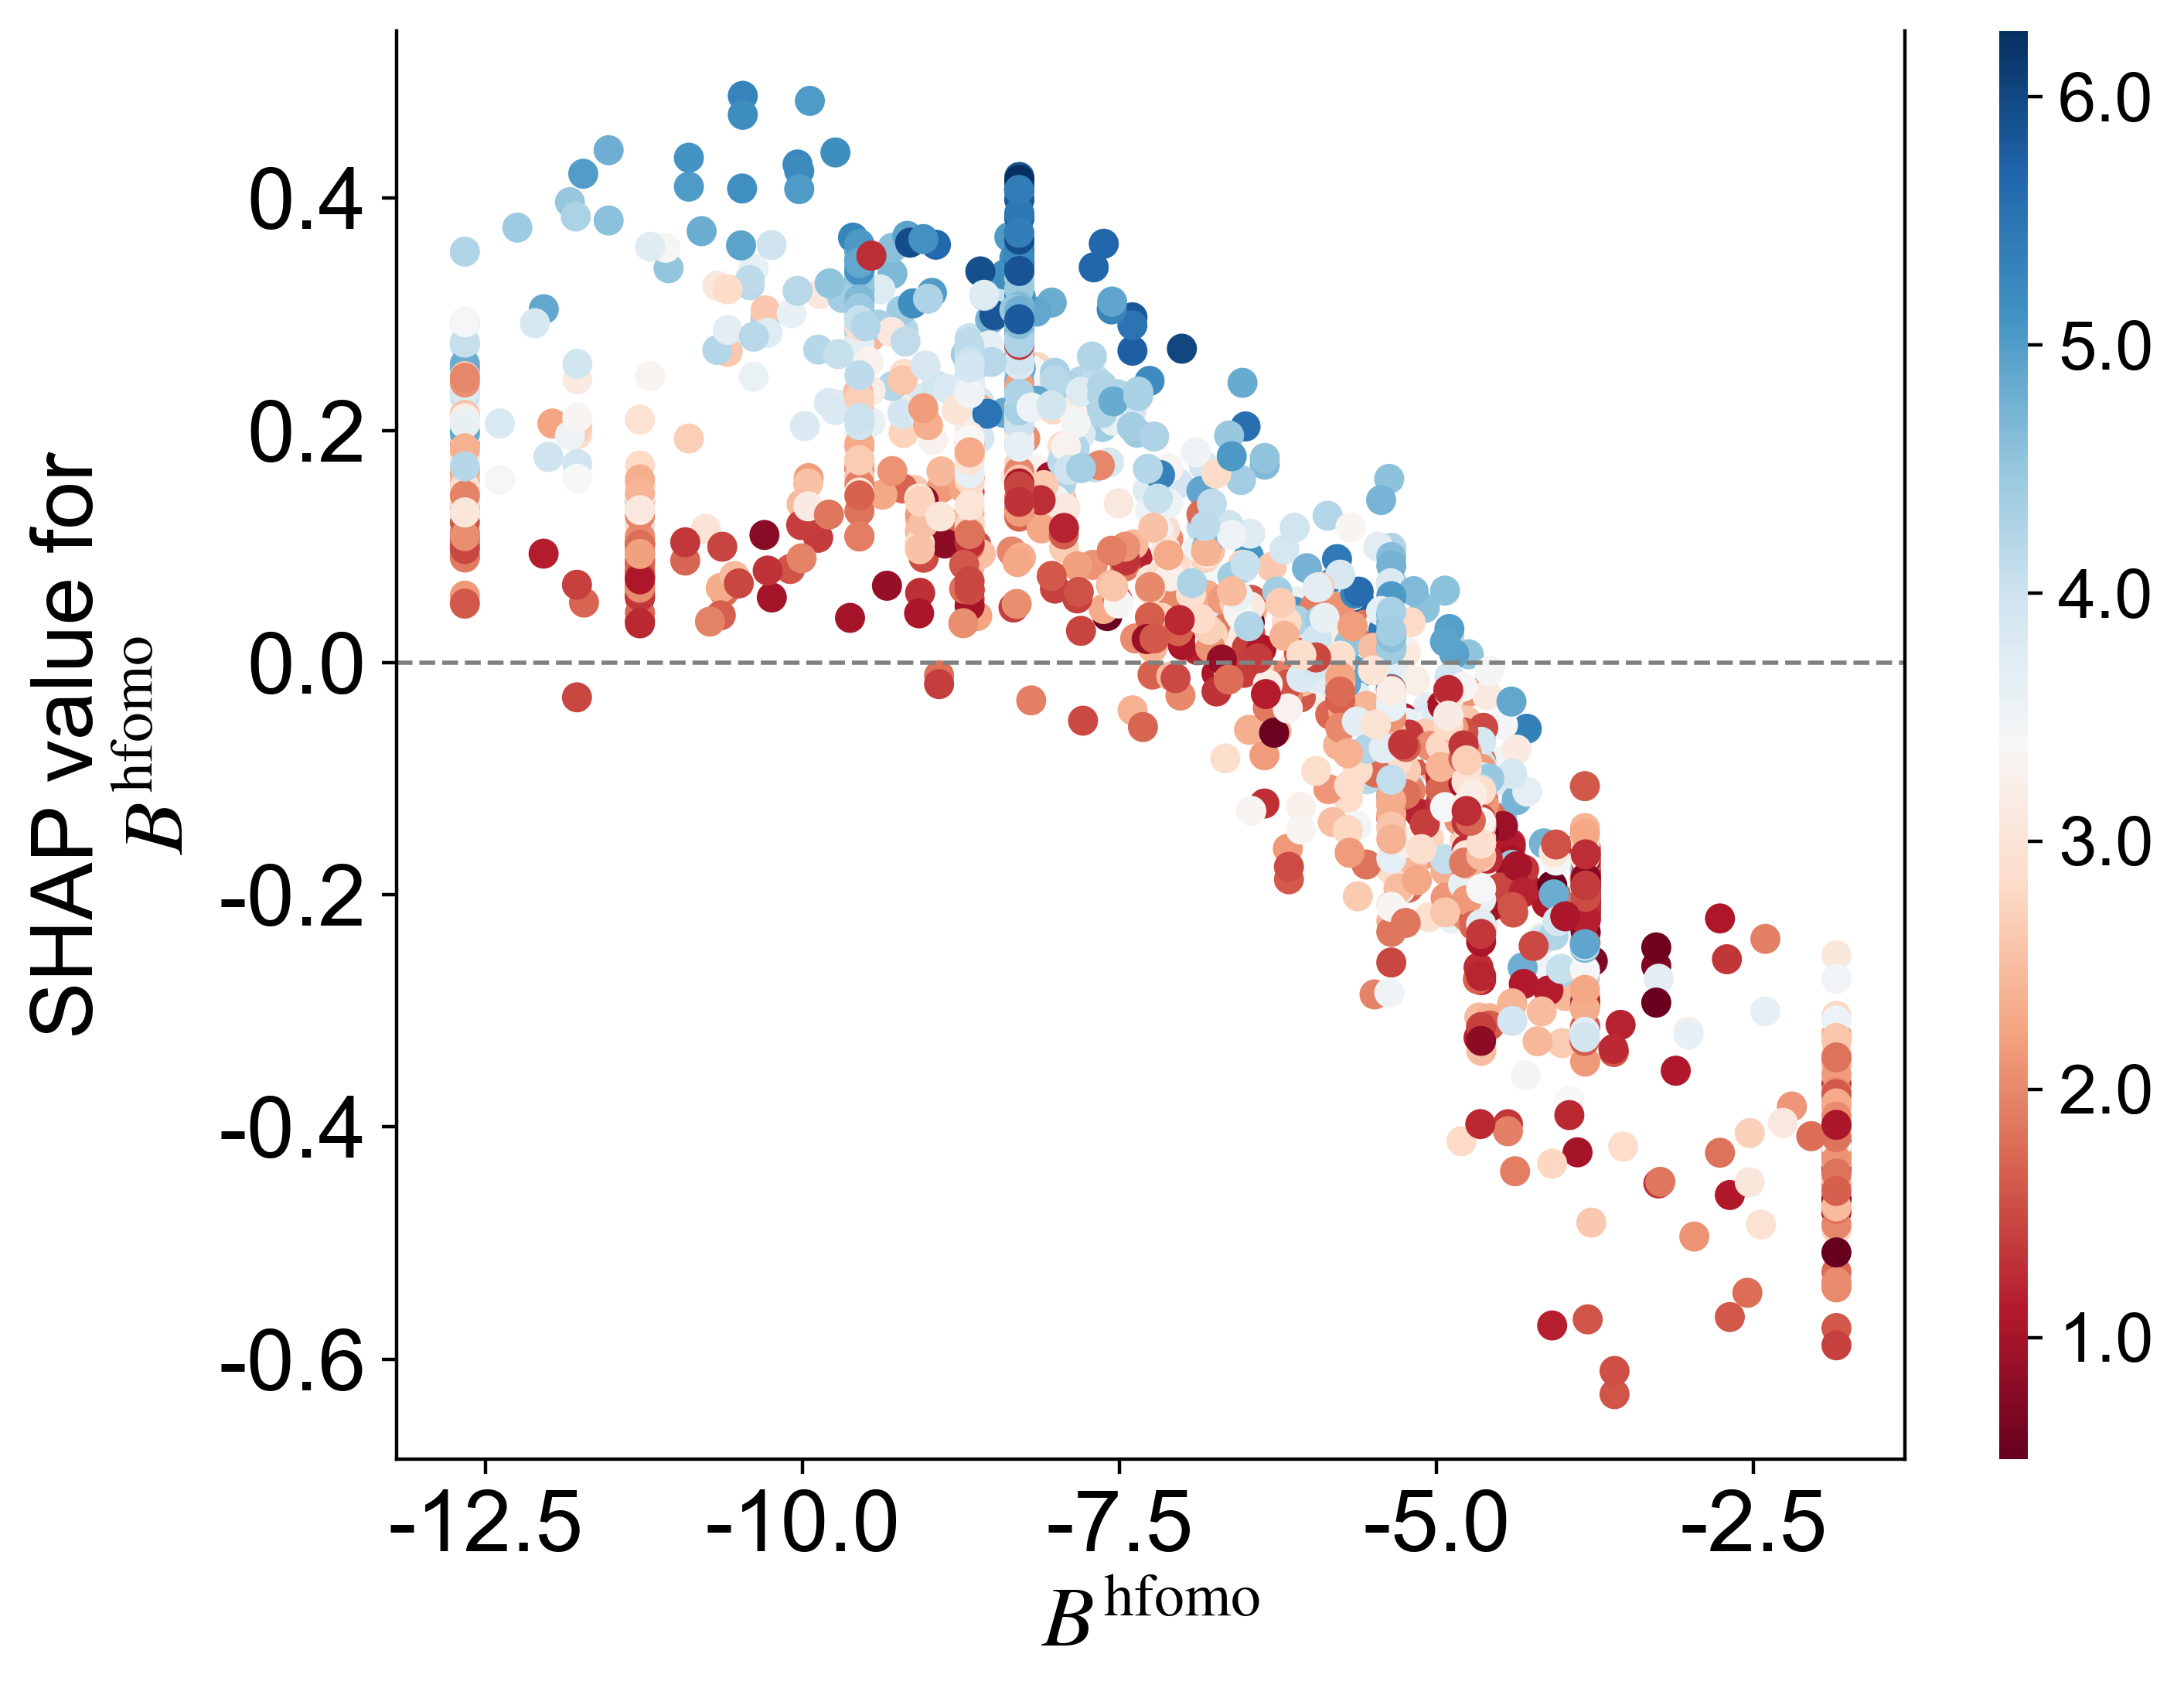

In [130]:
# shap.plots.scatter(shap_explanation[:, '$ B^{\mathrm{hfomo}}$'], color=best_y_test[test.index].values)
# plt.savefig("Bhfomo_shp.png", format='png', dpi=400, bbox_inches='tight')
fig, ax = plt.subplots(tight_layout=True, figsize=(8, 6))

# or you need more flexible customization
scatter = ax.scatter(
    shap_explanation[:, '$ B^{\mathrm{hfomo}}$'].data,
    shap_explanation[:, '$ B^{\mathrm{hfomo}}$'].values,
    c=best_y_test[test.index].values,
    cmap = "RdBu",
    marker="o",
    rasterized=True,
    zorder=0,
)

cbar = plt.colorbar(scatter, aspect=50, format="%2.1f")
cbar.outline.set_visible(False)

ax.set_xlabel('$ B^{\mathrm{hfomo}}$', fontsize=20)
ax.set_ylabel("SHAP value for\n$ B^{\mathrm{hfomo}}$", fontsize=20)
ax.tick_params(labelsize=20)

ax.grid(False)               # 关闭网格线
ax.spines['top'].set_visible(False)    # 隐藏上边框
# ax.spines['right'].set_visible(False)  # 隐藏右边框
# ax.spines['bottom'].set_color('#cccccc')  # 淡化下边框颜色
# ax.spines['left'].set_color('#cccccc')    # 淡化左边框颜色

# 4. 手动添加 y=0 虚线（红色虚线，突出显示）
ax.axhline(y=0, color='gray', linestyle='--', linewidth=1, zorder=0)
plt.savefig("Bhfomo_shp.png", format='png', dpi=400, bbox_inches='tight')
plt.show()

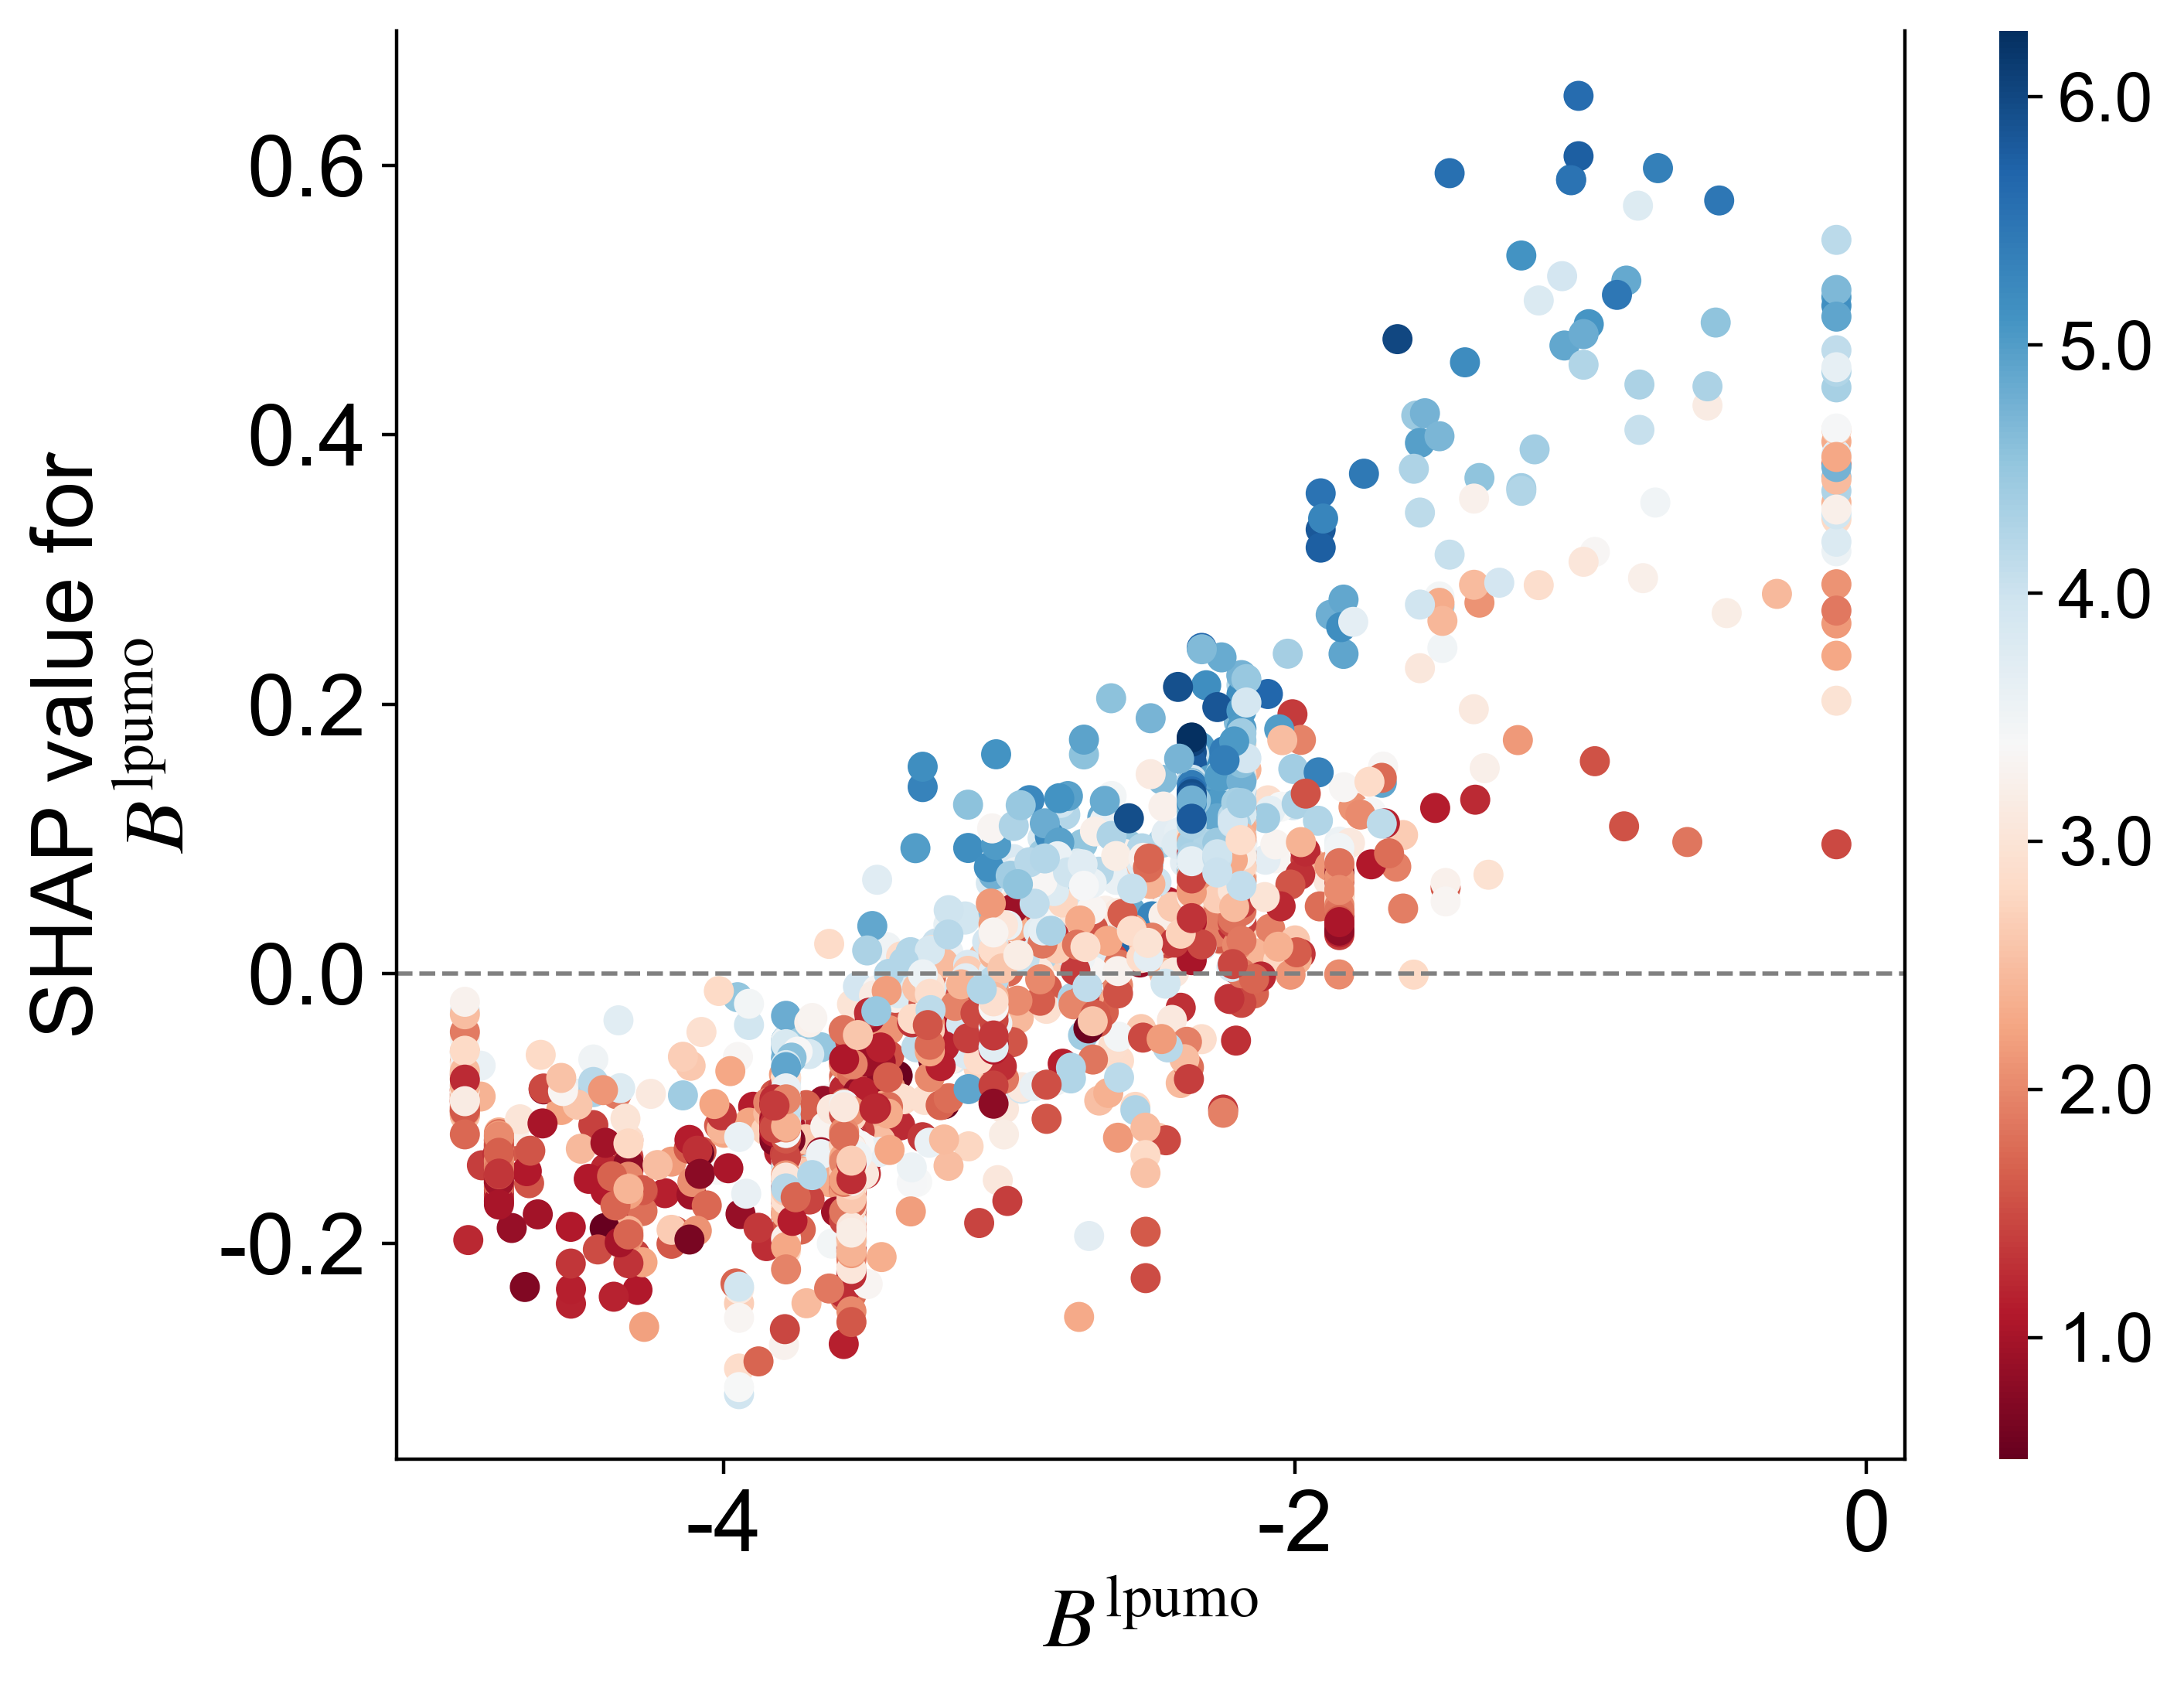

In [131]:
# shap.plots.scatter(shap_explanation[:, '$ B^{\mathrm{lpumo}}$'], color=best_y_test[test.index].values)
# plt.savefig("Blpumo_shp.png", format='png', dpi=400, bbox_inches='tight')
fig, ax = plt.subplots(tight_layout=True, figsize=(8, 6))

# or you need more flexible customization
scatter = ax.scatter(
    shap_explanation[:, '$ B^{\mathrm{lpumo}}$'].data,
    shap_explanation[:, '$ B^{\mathrm{lpumo}}$'].values,
    c=best_y_test[test.index].values,
    cmap = "RdBu",
    marker="o",
    rasterized=True,
    zorder=0,
)

cbar = plt.colorbar(scatter, aspect=50, format="%2.1f")
cbar.outline.set_visible(False)

ax.set_xlabel('$ B^{\mathrm{lpumo}}$', fontsize=20)
ax.set_ylabel("SHAP value for\n$ B^{\mathrm{lpumo}}$", fontsize=20)
ax.tick_params(labelsize=20)

ax.grid(False)               # 关闭网格线
ax.spines['top'].set_visible(False)    # 隐藏上边框
# ax.spines['right'].set_visible(False)  # 隐藏右边框
# ax.spines['bottom'].set_color('#cccccc')  # 淡化下边框颜色
# ax.spines['left'].set_color('#cccccc')    # 淡化左边框颜色

# 4. 手动添加 y=0 虚线（红色虚线，突出显示）
ax.axhline(y=0, color='gray', linestyle='--', linewidth=1, zorder=0)
plt.savefig("Blpumo_shp.png", format='png', dpi=400, bbox_inches='tight')
plt.show()

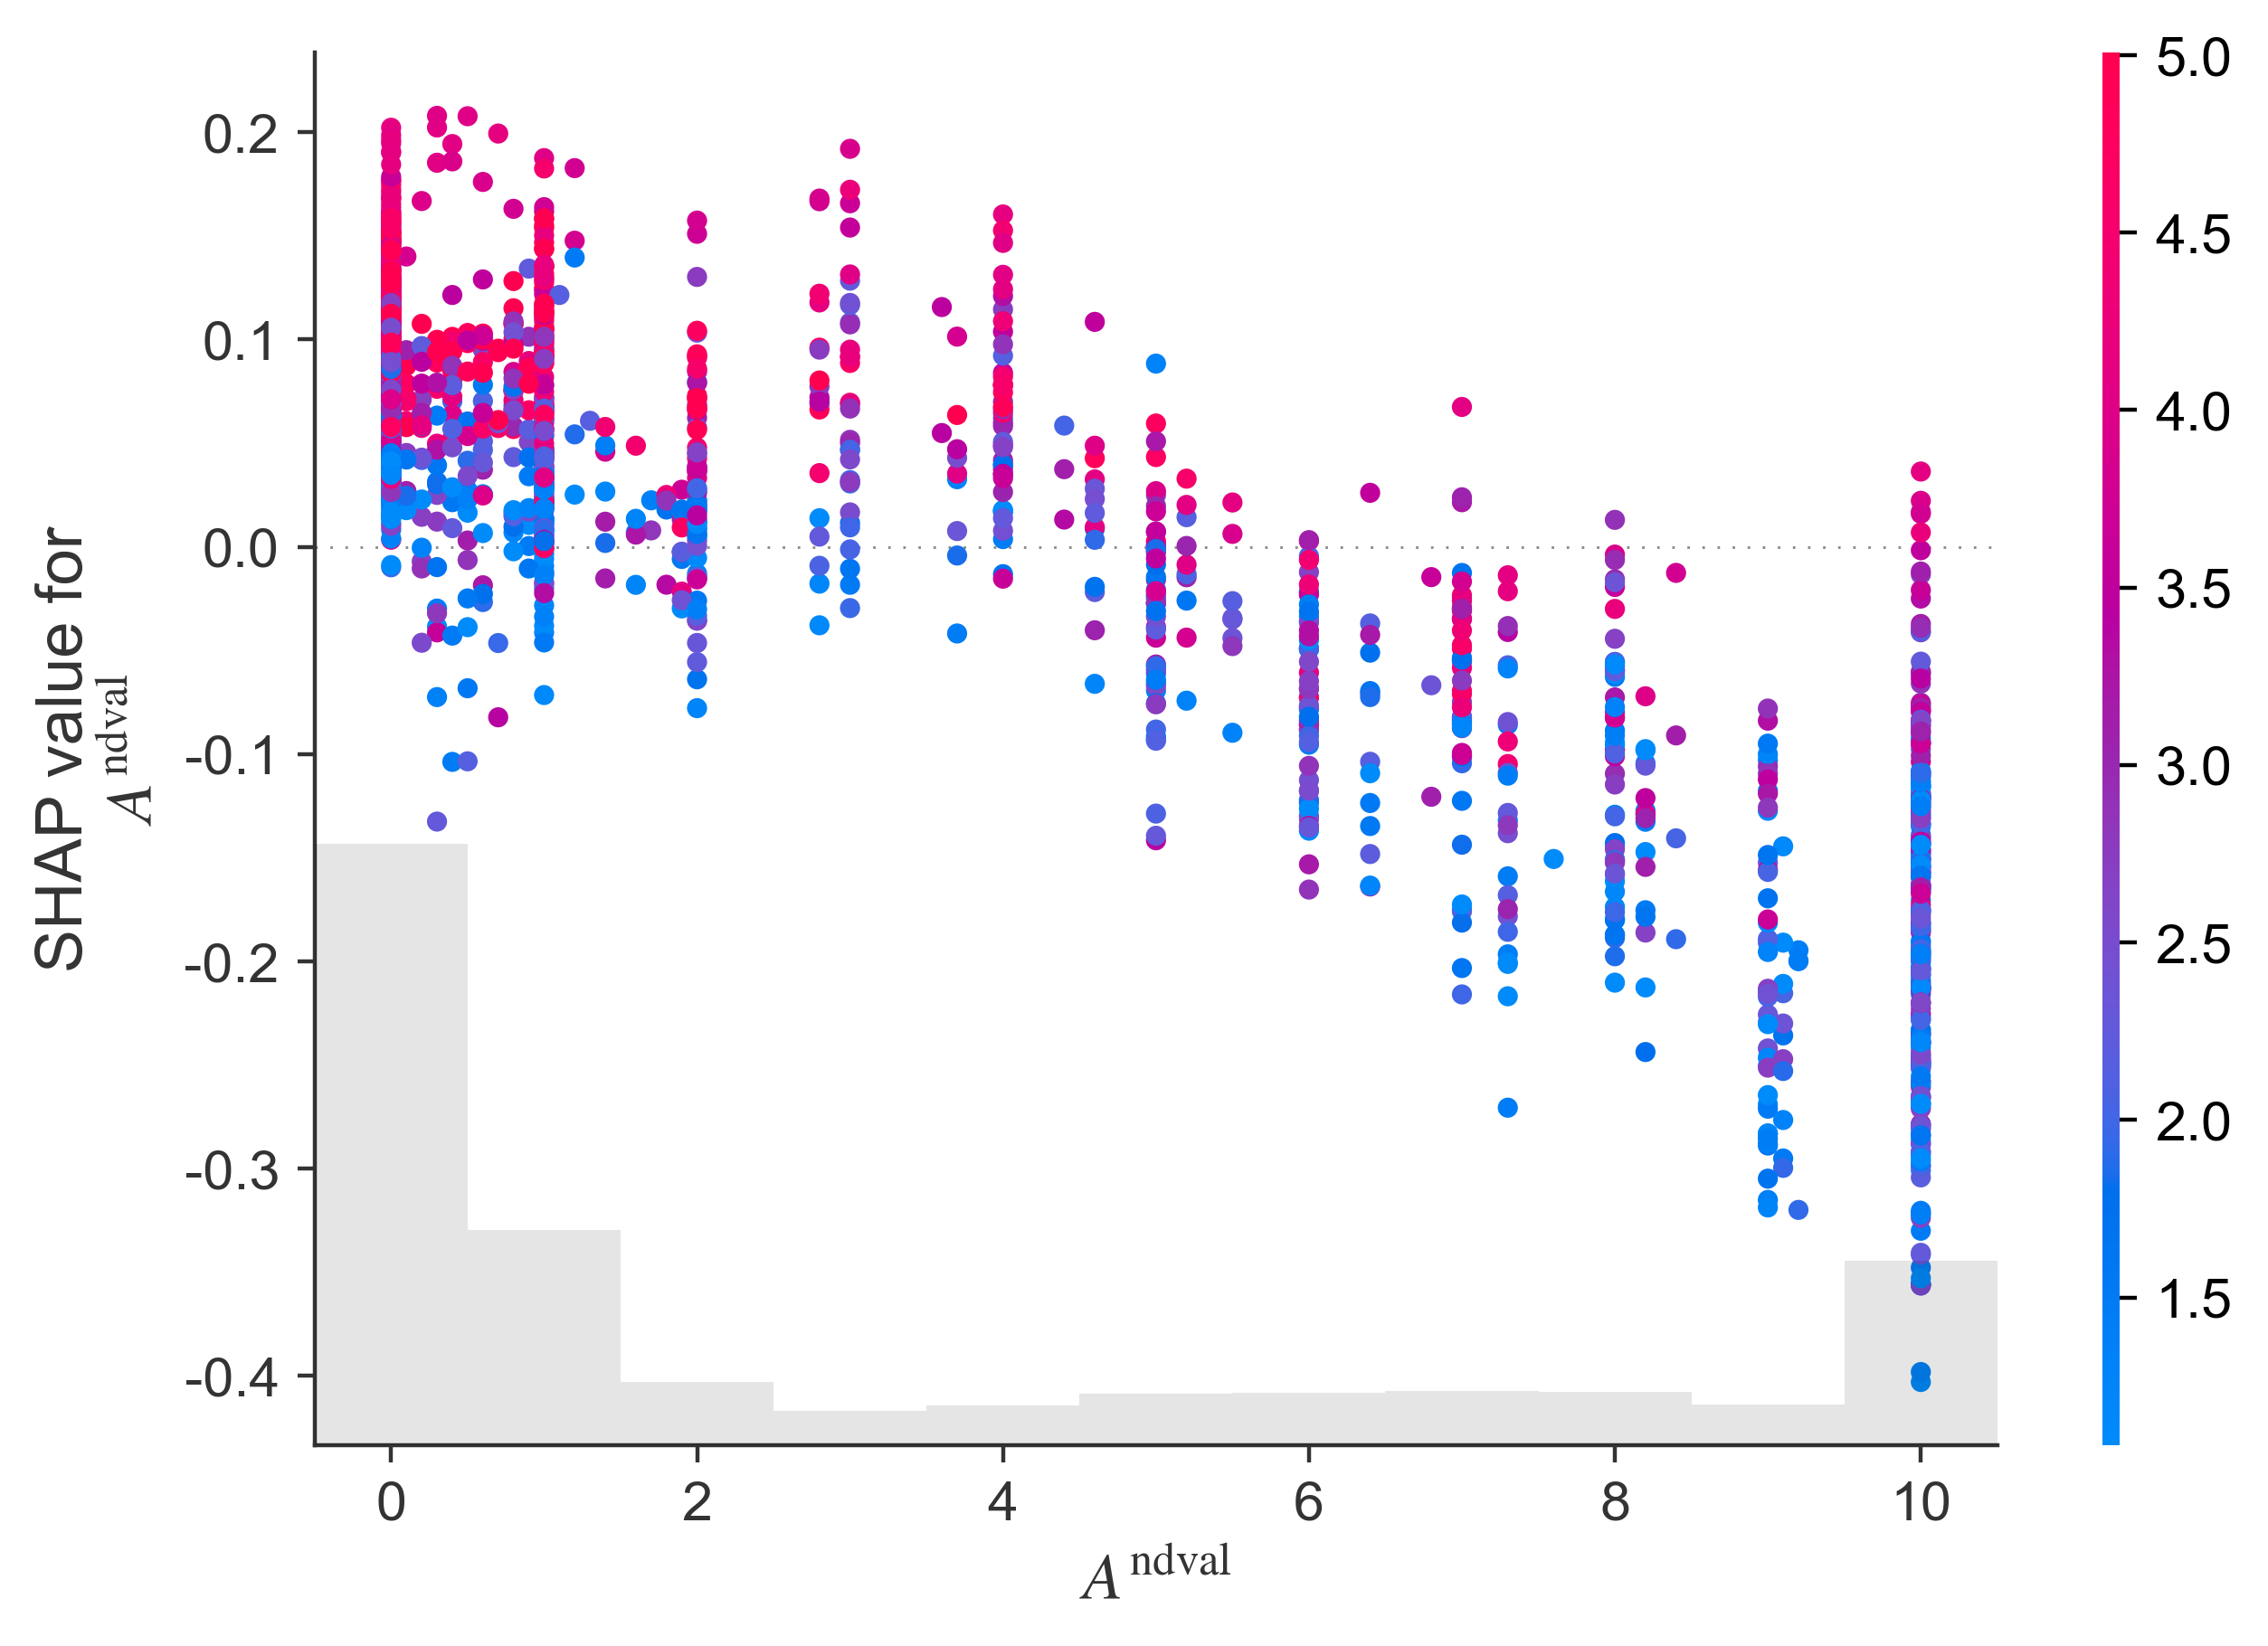

In [54]:
shap.plots.scatter(shap_explanation[:,  '$ A^{\mathrm{ndval}}$'], color=best_y_test[test.index].values)